In [9]:
# Load altair for visualizations
import altair as alt
alt.data_transformers.disable_max_rows()

# Load duckdb, which lets us efficiently load large files
import duckdb

# Load pandas, which lets us manipulate dataframes
import pandas as pd

# Import jupysql Jupyter extension to create SQL cells
%load_ext sql

# Set configrations on jupysql to directly output data to Pandas and to simplify the output that is printed to the notebook.
%config SqlMagic.autopandas = True

%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

# Allow named parameters (python variables) in SQL cells
%config SqlMagic.named_parameters=True

# Connect jupysql to DuckDB using a SQLAlchemy-style connection string. Either connect to an in memory DuckDB, or a file backed db.
%sql duckdb:///:memory:

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [11]:
df_top_cpt_codes_cost = pd.read_parquet('/Users/me/data/payless_health/top_cpt_by_cost.parquet') 
billing_code_to_description = {billing_code: description for billing_code, description in df_top_cpt_codes_cost[['billing_code', 'description']].values}

In [2]:
%%sql 
CREATE TABLE top_cpt_codes_by_cost AS SELECT * FROM '/Users/me/data/payless_health/top_cpt_by_cost.parquet';

Empty DataFrame
Columns: [Success]
Index: []

In [3]:
%%sql 
CREATE TABLE lenox AS SELECT * FROM '/Users/me/data/payless_health/EIN_131624070-lenox-hill.parquet';

Empty DataFrame
Columns: [Success]
Index: []

In [4]:
%%sql 
CREATE TABLE presbyterian AS SELECT * FROM '/Users/me/data/payless_health/EIN_133957095_newyork-presbyterian.parquet';

Empty DataFrame
Columns: [Success]
Index: []

In [5]:
%%sql 
CREATE TABLE mount_sinai AS SELECT * FROM '/Users/me/data/payless_health/EIN_131624096_mount-sinai.parquet';

Empty DataFrame
Columns: [Success]
Index: []

In [6]:
%%sql 
CREATE TABLE nyu_langone AS SELECT * FROM '/Users/me/data/payless_health/EIN_133971298_nyu-langone.parquet';

Empty DataFrame
Columns: [Success]
Index: []

In [90]:
%%sql 
WITH lenox_joined AS (
SELECT *, 'Northwell - Lenox Hill' AS hospital FROM lenox 
INNER JOIN top_cpt_codes_by_cost ON lenox.billing_code = top_cpt_codes_by_cost.billing_code
),

presbyterian_joined AS (
SELECT *, 'NewYork-Presbyterian' AS hospital FROM presbyterian
INNER JOIN top_cpt_codes_by_cost ON presbyterian.billing_code = top_cpt_codes_by_cost.billing_code
),

-- mount_sinai_joined AS (
-- SELECT *, 'Mount Sinai' AS hospital FROM mount_sinai
-- INNER JOIN top_cpt_codes_by_cost ON mount_sinai.billing_code = top_cpt_codes_by_cost.billing_code
-- ),

nyu_langone_joined AS (
SELECT *, 'NYU Langone - Tisch' AS hospital FROM nyu_langone
INNER JOIN top_cpt_codes_by_cost ON nyu_langone.billing_code = top_cpt_codes_by_cost.billing_code
)

SELECT * FROM 
(SELECT * FROM lenox_joined
 UNION ALL
 SELECT * FROM presbyterian_joined
  UNION ALL
  -- SELECT * FROM mount_sinai_joined
  -- UNION ALL
  SELECT * FROM nyu_langone_joined) 
WHERE billing_code IN (SELECT billing_code FROM presbyterian_joined)
AND billing_code IN (SELECT billing_code FROM lenox_joined)
-- AND billing_code IN (SELECT billing_code FROM mount_sinai_joined)
AND billing_code IN (SELECT billing_code FROM nyu_langone_joined)

billing_code                           description  \
0            93454             Coronary artery angio s&i   
1            93454             Coronary artery angio s&i   
2            93454             Coronary artery angio s&i   
3            93454             Coronary artery angio s&i   
4            93454             Coronary artery angio s&i   
...            ...                                   ...   
42943        90834  HC PSYCH THERAPY 45 MIN WITH PATIENT   
42944        90834  HC PSYCH THERAPY 45 MIN WITH PATIENT   
42945        90834  HC PSYCH THERAPY 45 MIN WITH PATIENT   
42946        90834  HC PSYCH THERAPY 45 MIN WITH PATIENT   
42947        90834  HC PSYCH THERAPY 45 MIN WITH PATIENT   

            health_insurance_name  negotiated_rate billing_code:1  \
0          Empire Blue Access EPO     20038.000000          93454   
1          Empire Blue Access PPO     20038.000000          93454   
2               Empire Bronze EPO     17296.000000          93454   
3          Empire Bronze Link EPO     17296.000000          93454   
4           Empire Connection EPO     17296.000000          93454   
...                           ...              ...            ...   
42943                First Health       188.121597          90834   
42944                   Magnacare       188.121597          90834   
42945  Multiplan/Beechstreet/PHCS       188.121597          90834   
42946                         QHM       188.121597          90834   
42947                   Worldwide       188.121597          90834   

                                           description:1  category  count  \
0      CATHETER PLACEMENT IN CORONARY ARTERY(S) FOR C...  Medicine     65   
1      CATHETER PLACEMENT IN CORONARY ARTERY(S) FOR C...  Medicine     65   
2      CATHETER PLACEMENT IN CORONARY ARTERY(S) FOR C...  Medicine     65   
3      CATHETER PLACEMENT IN CORONARY ARTERY(S) FOR C...  Medicine     65   
4      CATHETER PLACEMENT IN CORONARY ARTERY(S) FOR C...  Medicine     65   
...                                                  ...       ...    ...   
42943             PSYCHOTHERAPY, 45 MINUTES WITH PATIENT  Medicine   2466   
42944             PSYCHOTHERAPY, 45 MINUTES WITH PATIENT  Medicine   2466   
42945             PSYCHOTHERAPY, 45 MINUTES WITH PATIENT  Medicine   2466   
42946             PSYCHOTHERAPY, 45 MINUTES WITH PATIENT  Medicine   2466   
42947             PSYCHOTHERAPY, 45 MINUTES WITH PATIENT  Medicine   2466   

                     hospital  
0      Northwell - Lenox Hill  
1      Northwell - Lenox Hill  
2      Northwell - Lenox Hill  
3      Northwell - Lenox Hill  
4      Northwell - Lenox Hill  
...                       ...  
42943    NewYork-Presbyterian  
42944    NewYork-Presbyterian  
42945    NewYork-Presbyterian  
42946    NewYork-Presbyterian  
42947    NewYork-Presbyterian  

[42948 rows x 9 columns]

In [84]:
df = _

In [85]:
billing_code = '90832'
alt.Chart(df[df['billing_code'] == billing_code]).mark_boxplot().encode(
  alt.X("hospital:N", title="Hospital Name", axis=alt.Axis(labelAngle=-45)),
  alt.Y("negotiated_rate:Q", axis=alt.Axis(format='$.0f'), title=f"Price Listed by Hospital (Across Health Insurance Products)").scale(zero=False),
).properties(
title=[f"Current Procedural Terminology (CPT) code {billing_code}:",
  f"{billing_code_to_description[billing_code].split(',')[0].lower().capitalize()}"]
).display()

alt.Chart(...)

In [44]:
health_insurance_names = {
  'medicare': ['medicare', 'mdcr', 'mediblue'],
  'medicaid': ['medicaid', 'mdcd'],
  'aetna': ['aetna'],
  'empire': ['empire', 'blue cross', 'bcbs'],
  'healthfirst': ['healthfirst'],
  'oxford': ['oxford'],
  'united': ['united'],
  'cigna': ['cigna'],
  'healthnet': ['healthnet'],
  'humana': ['humana'],
  'emblem': ['emblem'],
  'metroplus': ['metroplus'],
  'mvp': ['mvp'],
  '32bj': ['32bj'],
  'fidelis': ['fidelis'],
  'affinity': ['affinity'],
  'amida': ['amida'],
  'centerlight': ['centerlight'],
  'elderplan': ['elderplan'],
  'vnsny': ['vnsny'],
  'wellcare': ['wellcare'],
  '1199': ['1199', '1199seiu'],
  '1199seiu': ['1199seiu'],  
}
df.health_insurance_name.str.contains('|'.join(health_insurance_names['empire']), case=False) & ~df.hospital.str.contains('|'.join(health_insurance_names['medicare']), case=False) & ~df.hospital.str.contains('|'.join(health_insurance_names['medicaid']), case=False)

0         True
1         True
2         True
3         True
4         True
         ...  
32887    False
32888    False
32889    False
32890    False
32891    False
Length: 32892, dtype: bool

In [62]:
df[df.health_insurance_name.str.contains('|'.join(health_insurance_names['aetna']), case=False) & ~df.hospital.str.contains('|'.join(health_insurance_names['medicare']), case=False) & ~df.hospital.str.contains('|'.join(health_insurance_names['medicaid']), case=False)].hospital.value_counts()

NYU Langone - Tisch       683
Northwell - Lenox Hill    633
NewYork-Presbyterian       59
Name: hospital, dtype: int64

In [91]:
# df.loc[df.health_insurance_name.str.contains('|'.join(health_insurance_names['medicare']), case=False), 'insurance_group'] = 'Medicare'
# df.loc[df.health_insurance_name.str.contains('|'.join(health_insurance_names['medicaid']), case=False), 'insurance_group'] = 'Medicaid'
df.loc[df.health_insurance_name.str.contains('|'.join(health_insurance_names['aetna']), case=False) & ~df.hospital.str.contains('|'.join(health_insurance_names['medicare']), case=False) & ~df.hospital.str.contains('|'.join(health_insurance_names['medicaid']), case=False), 'insurance_group'] = 'Aetna'
df.loc[df.health_insurance_name.str.contains('|'.join(health_insurance_names['united']), case=False) & ~df.hospital.str.contains('|'.join(health_insurance_names['medicare']), case=False) & ~df.hospital.str.contains('|'.join(health_insurance_names['medicaid']), case=False), 'insurance_group'] = 'United'
# df.loc[df.health_insurance_name.str.contains('|'.join(health_insurance_names['cigna']), case=False) & ~df.hospital.str.contains('|'.join(health_insurance_names['medicare']), case=False) & ~df.hospital.str.contains('|'.join(health_insurance_names['medicaid']), case=False), 'insurance_group'] = 'Cigna'
df.loc[df.health_insurance_name.str.contains('|'.join(health_insurance_names['empire']), case=False) & ~df.hospital.str.contains('|'.join(health_insurance_names['medicare']), case=False) & ~df.hospital.str.contains('|'.join(health_insurance_names['medicaid']), case=False), 'insurance_group'] = 'Empire Blue Cross'
# df.loc[df.health_insurance_name.str.contains('|'.join(health_insurance_names['humana']), case=False) & ~df.hospital.str.contains('|'.join(health_insurance_names['medicare']), case=False) & ~df.hospital.str.contains('|'.join(health_insurance_names['medicaid']), case=False), 'insurance_group'] = 'Humana'


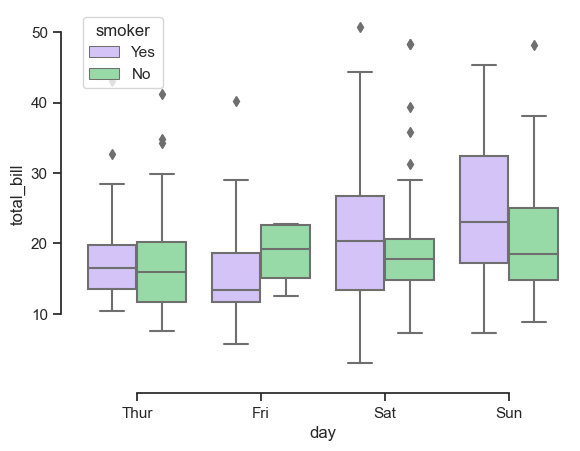

In [92]:
import seaborn as sns
sns.set_theme(style="ticks", palette="pastel")
import matplotlib.pyplot as plt

# Load the example tips dataset
tips = sns.load_dataset("tips")

# Draw a nested boxplot to show bills by day and time
sns.boxplot(x="day", y="total_bill",
            hue="smoker", palette=["m", "g"],
            data=tips)
sns.despine(offset=10, trim=True)

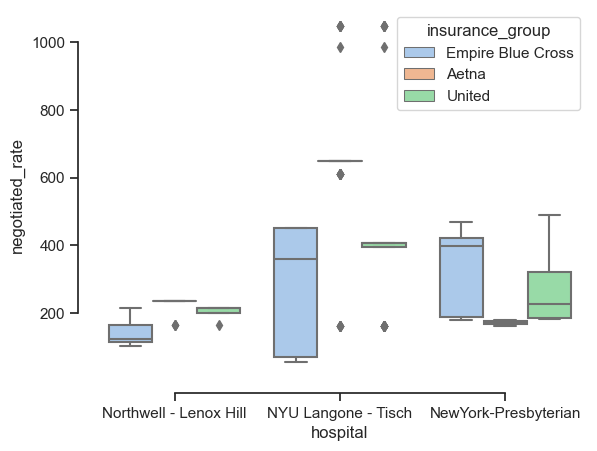

In [94]:
# Draw a nested boxplot to show bills by day and time
billing_code = '90832'
sns.boxplot(x="hospital", y="negotiated_rate",
            hue="insurance_group", 
            hue_order=["Empire Blue Cross", "Aetna", "United"],
            #palette=["m", "g"],
            data=df[df['billing_code'] == billing_code])
sns.despine(offset=10, trim=True)

# Plot CPT codes by insurer

99284
hospital                insurance_group  
NYU Langone - Tisch     Empire Blue Cross    122
                        Medicare              62
                        United                30
                        Aetna                 24
                        Medicaid               6
NewYork-Presbyterian    Medicare               6
                        Aetna                  2
                        Empire Blue Cross      2
                        United                 2
Northwell - Lenox Hill  Empire Blue Cross     33
                        Aetna                 24
                        Medicare               9
                        United                 4
                        Medicaid               1
Name: insurance_group, dtype: int64


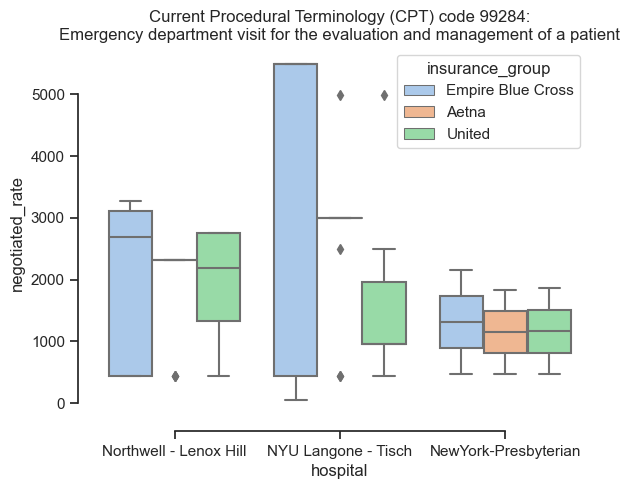

99285
hospital                insurance_group  
NYU Langone - Tisch     Empire Blue Cross    122
                        Medicare              62
                        United                30
                        Aetna                 24
                        Medicaid               6
NewYork-Presbyterian    Medicare               6
                        Aetna                  2
                        Empire Blue Cross      2
                        United                 2
Northwell - Lenox Hill  Empire Blue Cross     33
                        Aetna                 24
                        Medicare               9
                        United                 4
                        Medicaid               1
Name: insurance_group, dtype: int64


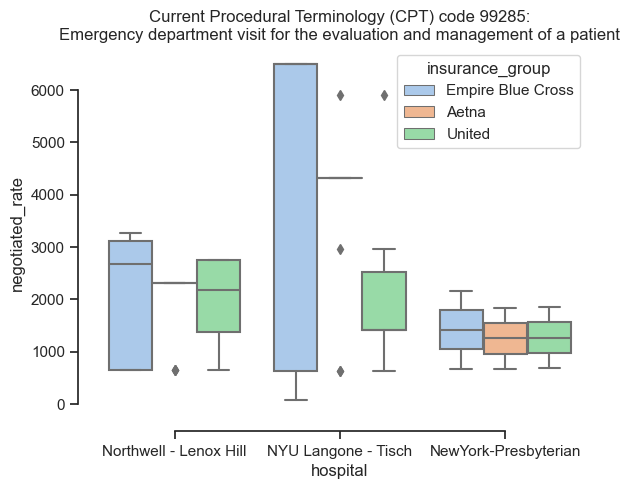

99283
hospital                insurance_group  
NYU Langone - Tisch     Empire Blue Cross    122
                        Medicare              62
                        United                30
                        Aetna                 24
                        Medicaid               6
NewYork-Presbyterian    Medicare               6
                        Aetna                  2
                        Empire Blue Cross      2
                        United                 2
Northwell - Lenox Hill  Empire Blue Cross     33
                        Aetna                 24
                        Medicare               9
                        United                 4
                        Medicaid               1
Name: insurance_group, dtype: int64


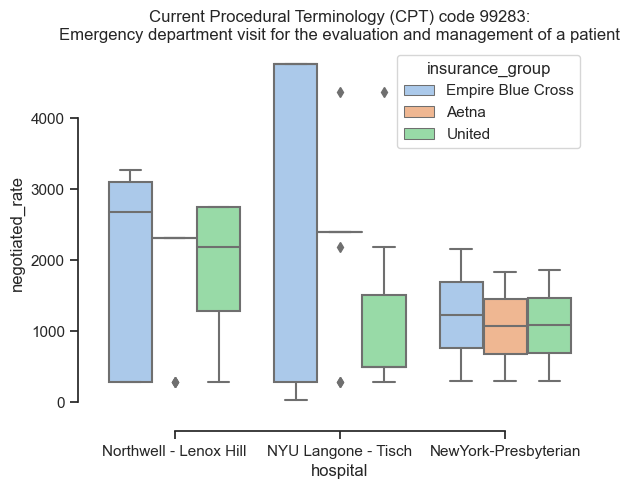

99282
hospital                insurance_group  
NYU Langone - Tisch     Empire Blue Cross    122
                        Medicare              62
                        United                30
                        Aetna                 24
                        Medicaid               6
NewYork-Presbyterian    Medicare               6
                        Aetna                  2
                        Empire Blue Cross      2
                        United                 2
Northwell - Lenox Hill  Empire Blue Cross     33
                        Aetna                 24
                        Medicare               9
                        United                 4
                        Medicaid               1
Name: insurance_group, dtype: int64


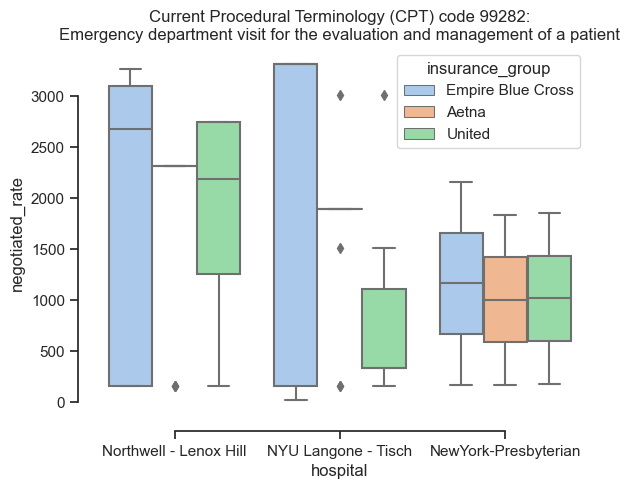

99214
99281
hospital                insurance_group  
NYU Langone - Tisch     Empire Blue Cross    244
                        Medicare             124
                        United                60
                        Aetna                 48
                        Medicaid              12
NewYork-Presbyterian    Medicare               6
                        Aetna                  2
                        Empire Blue Cross      2
                        United                 2
Northwell - Lenox Hill  Empire Blue Cross     33
                        Aetna                 24
                        Medicare               9
                        United                 4
                        Medicaid               1
Name: insurance_group, dtype: int64


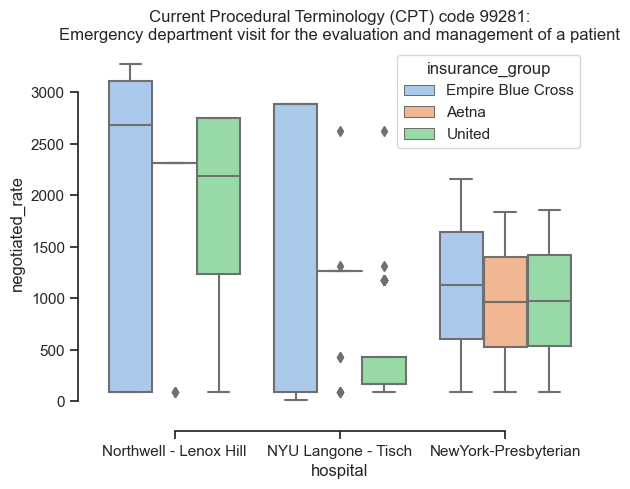

99291
99213
99218
99219
99212
99215
99203
99220
99211
96413
93458
hospital                insurance_group  
NYU Langone - Tisch     Empire Blue Cross    146
                        Medicare              62
                        United                29
                        Medicaid              26
                        Aetna                 23
NewYork-Presbyterian    Medicaid               7
                        Medicare               6
                        Empire Blue Cross      5
                        United                 4
                        Aetna                  2
Northwell - Lenox Hill  Empire Blue Cross     38
                        Aetna                 24
                        Medicare               9
                        United                 7
                        Medicaid               6
Name: insurance_group, dtype: int64


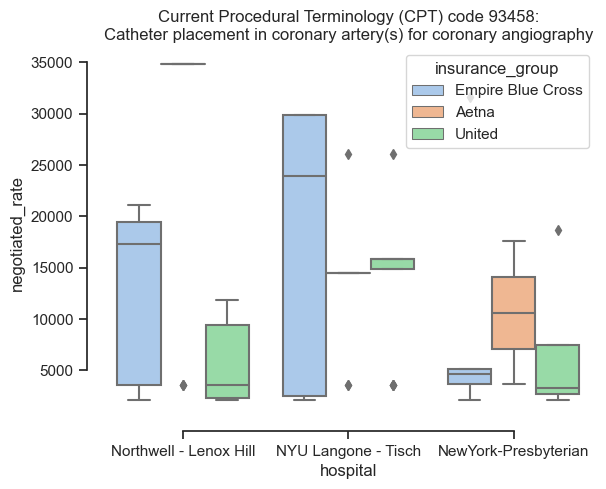

96374
96365
96372
93306
96375
93454
hospital                insurance_group  
NYU Langone - Tisch     Empire Blue Cross    146
                        Medicare              62
                        United                29
                        Medicaid              26
                        Aetna                 23
NewYork-Presbyterian    Medicaid               7
                        Medicare               6
                        Empire Blue Cross      5
                        United                 4
                        Aetna                  2
Northwell - Lenox Hill  Empire Blue Cross     38
                        Aetna                 24
                        Medicare               9
                        United                 7
                        Medicaid               6
Name: insurance_group, dtype: int64


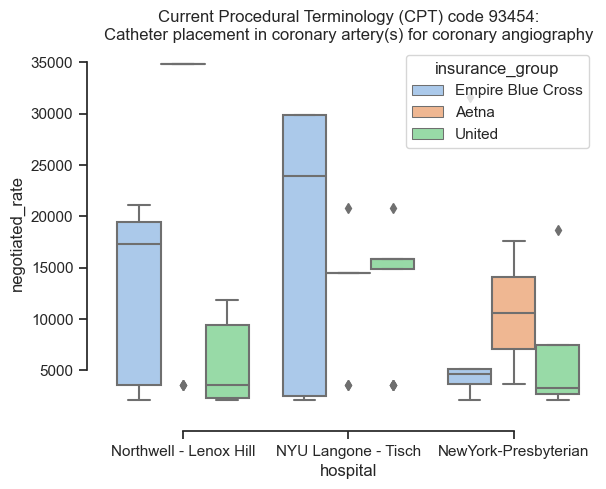

96361
90832
hospital                insurance_group  
NYU Langone - Tisch     Empire Blue Cross    511
                        Medicare             217
                        United               105
                        Medicaid              91
                        Aetna                 84
NewYork-Presbyterian    Medicaid               7
                        Medicare               6
                        Empire Blue Cross      5
                        United                 4
                        Aetna                  2
Northwell - Lenox Hill  Empire Blue Cross     38
                        Aetna                 24
                        Medicare               9
                        Medicaid               6
                        United                 4
Name: insurance_group, dtype: int64


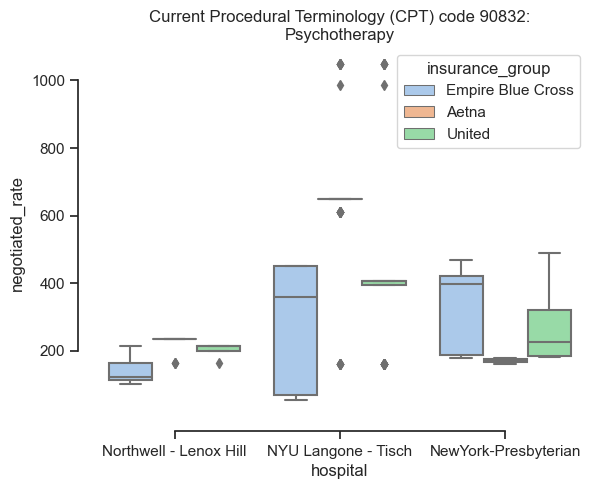

93005
hospital                insurance_group  
NYU Langone - Tisch     Empire Blue Cross    146
                        Medicare              62
                        United                30
                        Aetna                 24
                        Medicaid               6
NewYork-Presbyterian    Medicaid               7
                        Medicare               6
                        Empire Blue Cross      5
                        United                 4
                        Aetna                  2
Northwell - Lenox Hill  Empire Blue Cross     38
                        Aetna                 24
                        Medicare               9
                        United                 7
                        Medicaid               6
Name: insurance_group, dtype: int64


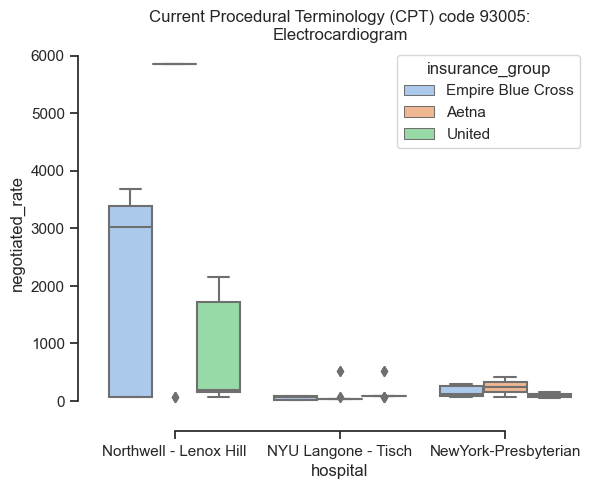

92978
hospital                insurance_group  
NYU Langone - Tisch     Empire Blue Cross    42
                        United               25
                        Medicaid             24
                        Aetna                21
NewYork-Presbyterian    Medicaid              7
                        Empire Blue Cross     4
                        United                3
                        Aetna                 1
Northwell - Lenox Hill  Empire Blue Cross    26
                        Aetna                21
                        United                6
                        Medicaid              5
Name: insurance_group, dtype: int64


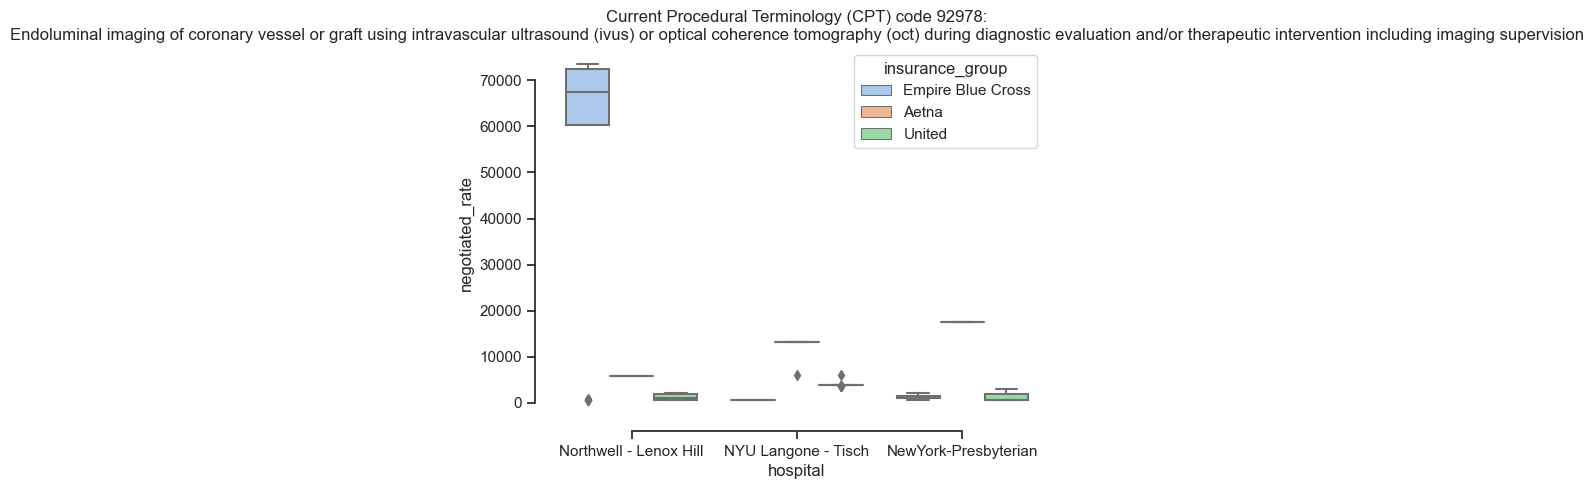

96360
96402
90834
hospital                insurance_group  
NYU Langone - Tisch     Empire Blue Cross    511
                        Medicare             217
                        United               105
                        Medicaid              91
                        Aetna                 84
NewYork-Presbyterian    Medicaid               7
                        Medicare               6
                        Empire Blue Cross      5
                        United                 4
                        Aetna                  2
Northwell - Lenox Hill  Empire Blue Cross     38
                        Aetna                 24
                        Medicare               9
                        Medicaid               6
                        United                 4
Name: insurance_group, dtype: int64


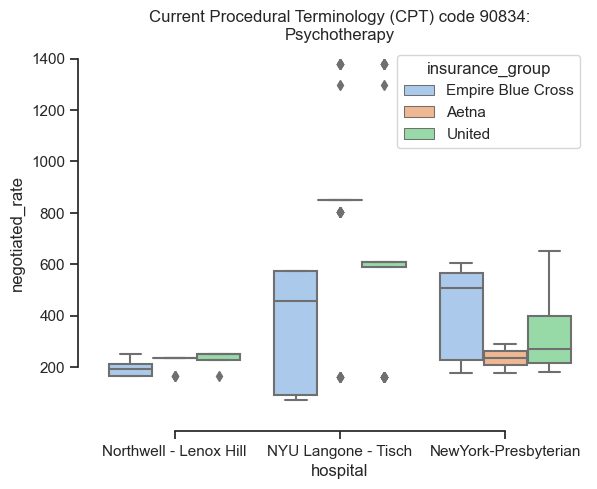

80053
hospital                insurance_group  
NYU Langone - Tisch     Empire Blue Cross    51
                        United               13
                        Medicaid             12
                        Aetna                11
                        Medicare              5
NewYork-Presbyterian    Medicaid              7
                        Medicare              6
                        Empire Blue Cross     5
                        United                4
                        Aetna                 2
Northwell - Lenox Hill  Empire Blue Cross    38
                        Aetna                24
                        Medicare              9
                        United                7
                        Medicaid              6
Name: insurance_group, dtype: int64


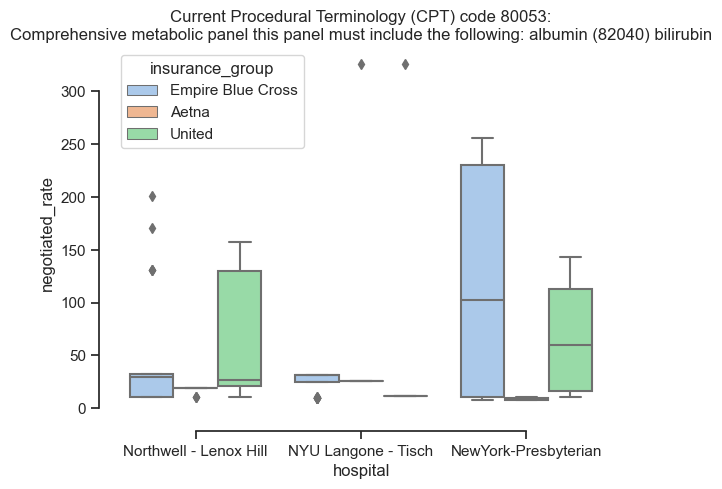

88305
85025
hospital                insurance_group  
NYU Langone - Tisch     Empire Blue Cross    64
                        United               13
                        Aetna                11
                        Medicare              5
                        Medicaid              2
NewYork-Presbyterian    Medicaid              7
                        Medicare              6
                        Empire Blue Cross     5
                        United                4
                        Aetna                 2
Northwell - Lenox Hill  Empire Blue Cross    38
                        Aetna                24
                        Medicare              9
                        United                7
                        Medicaid              6
Name: insurance_group, dtype: int64


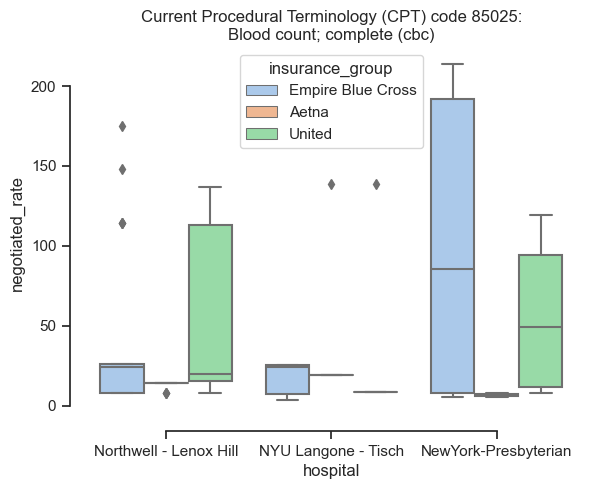

88185
80048
hospital                insurance_group  
NYU Langone - Tisch     Empire Blue Cross    51
                        United               13
                        Medicaid             12
                        Aetna                11
                        Medicare              5
NewYork-Presbyterian    Medicaid              7
                        Medicare              6
                        Empire Blue Cross     5
                        United                4
                        Aetna                 2
Northwell - Lenox Hill  Empire Blue Cross    38
                        Aetna                24
                        Medicare              9
                        United                7
                        Medicaid              6
Name: insurance_group, dtype: int64


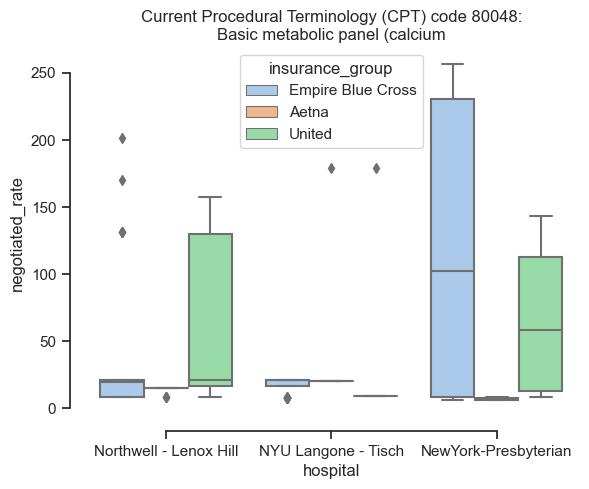

80061
hospital                insurance_group  
NYU Langone - Tisch     Empire Blue Cross    60
                        Medicare             31
                        United               15
                        Medicaid             13
                        Aetna                12
NewYork-Presbyterian    Medicaid              7
                        Medicare              6
                        Empire Blue Cross     5
                        United                4
                        Aetna                 2
Northwell - Lenox Hill  Empire Blue Cross    38
                        Aetna                24
                        Medicare              9
                        United                7
                        Medicaid              6
Name: insurance_group, dtype: int64


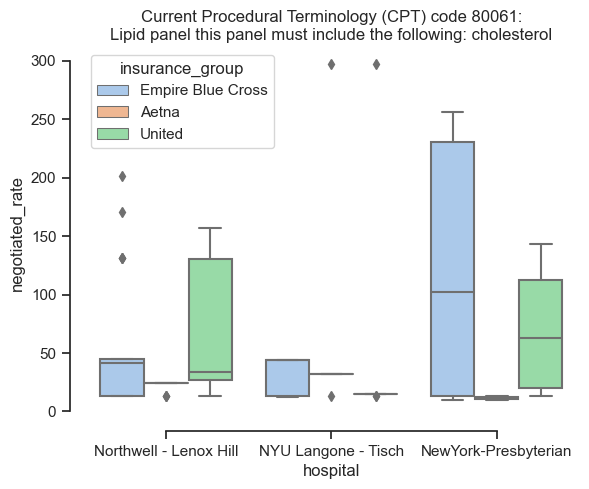

84443
hospital                insurance_group  
NYU Langone - Tisch     Empire Blue Cross    51
                        United               13
                        Aetna                11
                        Medicare              5
                        Medicaid              2
NewYork-Presbyterian    Medicaid              7
                        Medicare              6
                        Empire Blue Cross     5
                        United                4
                        Aetna                 2
Northwell - Lenox Hill  Empire Blue Cross    38
                        Aetna                24
                        Medicare              9
                        United                7
                        Medicaid              6
Name: insurance_group, dtype: int64


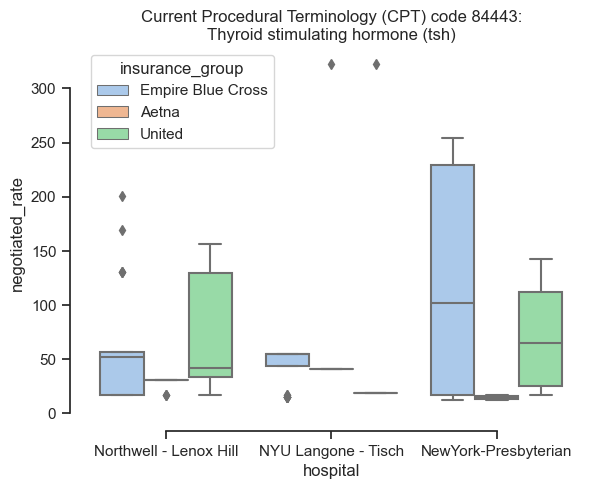

87491
hospital                insurance_group  
NYU Langone - Tisch     Empire Blue Cross    51
                        United               13
                        Medicaid             12
                        Aetna                11
                        Medicare              5
NewYork-Presbyterian    Medicaid              7
                        Medicare              6
                        Empire Blue Cross     5
                        United                4
                        Aetna                 2
Northwell - Lenox Hill  Empire Blue Cross    38
                        Aetna                24
                        Medicare              9
                        United                7
                        Medicaid              6
Name: insurance_group, dtype: int64


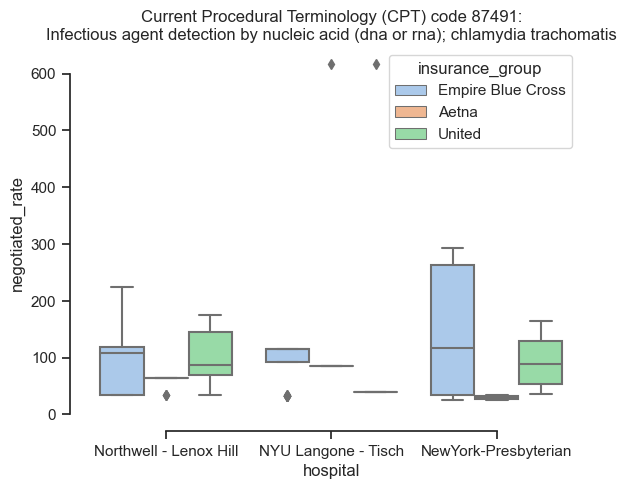

82306
hospital                insurance_group  
NYU Langone - Tisch     Empire Blue Cross    51
                        United               13
                        Medicaid             12
                        Aetna                11
                        Medicare              5
NewYork-Presbyterian    Medicaid              7
                        Medicare              6
                        Empire Blue Cross     5
                        United                4
                        Aetna                 2
Northwell - Lenox Hill  Empire Blue Cross    38
                        Aetna                24
                        Medicare              9
                        United                7
                        Medicaid              6
Name: insurance_group, dtype: int64


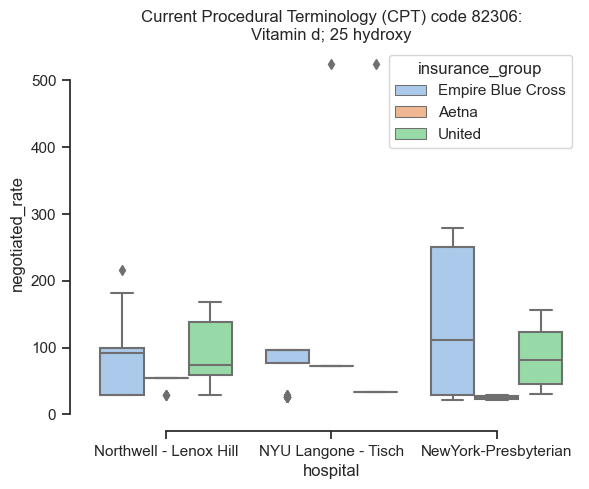

87591
hospital                insurance_group  
NYU Langone - Tisch     Empire Blue Cross    51
                        United               13
                        Medicaid             12
                        Aetna                11
                        Medicare              5
NewYork-Presbyterian    Medicaid              7
                        Medicare              6
                        Empire Blue Cross     5
                        United                4
                        Aetna                 2
Northwell - Lenox Hill  Empire Blue Cross    38
                        Aetna                24
                        Medicare              9
                        United                7
                        Medicaid              6
Name: insurance_group, dtype: int64


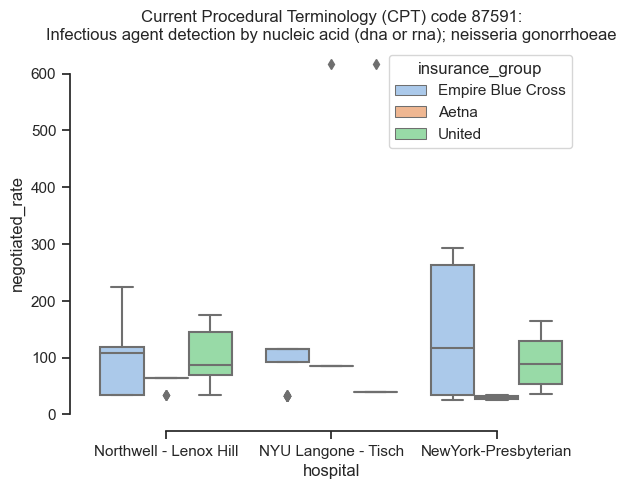

84484
hospital                insurance_group  
NYU Langone - Tisch     Empire Blue Cross    51
                        United               13
                        Aetna                11
                        Medicare              5
                        Medicaid              2
NewYork-Presbyterian    Medicaid              7
                        Medicare              6
                        Empire Blue Cross     5
                        United                4
                        Aetna                 2
Northwell - Lenox Hill  Empire Blue Cross    38
                        Aetna                24
                        Medicare              9
                        United                7
                        Medicaid              6
Name: insurance_group, dtype: int64


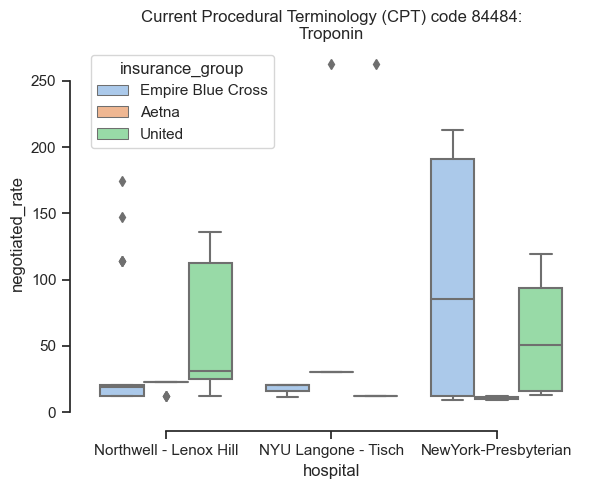

87636
83036
hospital                insurance_group  
NYU Langone - Tisch     Empire Blue Cross    51
                        United               13
                        Aetna                11
                        Medicare              5
                        Medicaid              2
NewYork-Presbyterian    Medicaid              7
                        Medicare              6
                        Empire Blue Cross     5
                        United                4
                        Aetna                 2
Northwell - Lenox Hill  Empire Blue Cross    38
                        Aetna                24
                        Medicare              9
                        United                7
                        Medicaid              6
Name: insurance_group, dtype: int64


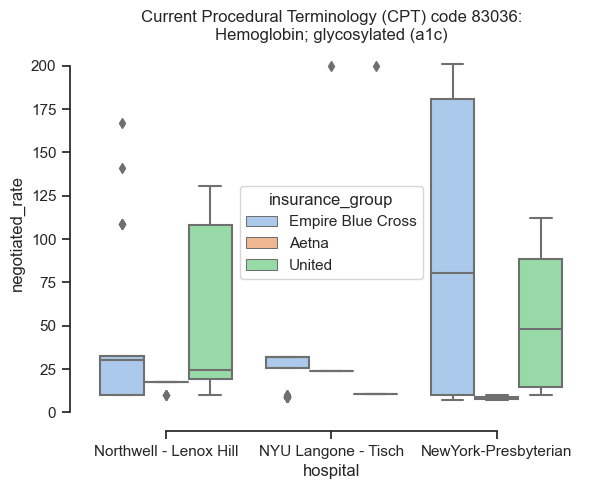

81408
hospital                insurance_group  
NYU Langone - Tisch     Medicare             31
                        United               15
                        Aetna                12
                        Empire Blue Cross    11
                        Medicaid              2
NewYork-Presbyterian    Medicare              6
                        Aetna                 2
                        Empire Blue Cross     2
                        United                2
Northwell - Lenox Hill  Empire Blue Cross    33
                        Aetna                24
                        Medicare              9
                        United                4
                        Medicaid              1
Name: insurance_group, dtype: int64


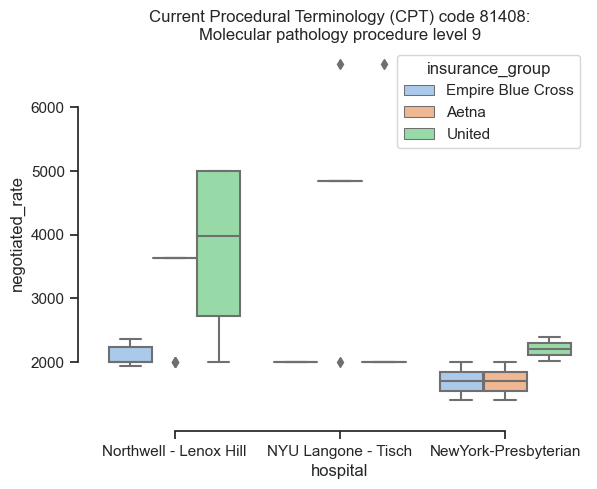

87635
77386
hospital                insurance_group  
NYU Langone - Tisch     Empire Blue Cross    73
                        Medicare             31
                        United               15
                        Medicaid             13
                        Aetna                12
NewYork-Presbyterian    Medicaid              7
                        Medicare              6
                        Empire Blue Cross     4
                        United                4
                        Aetna                 2
Northwell - Lenox Hill  Empire Blue Cross    38
                        Medicare              9
                        United                7
                        Medicaid              6
                        Aetna                 3
Name: insurance_group, dtype: int64


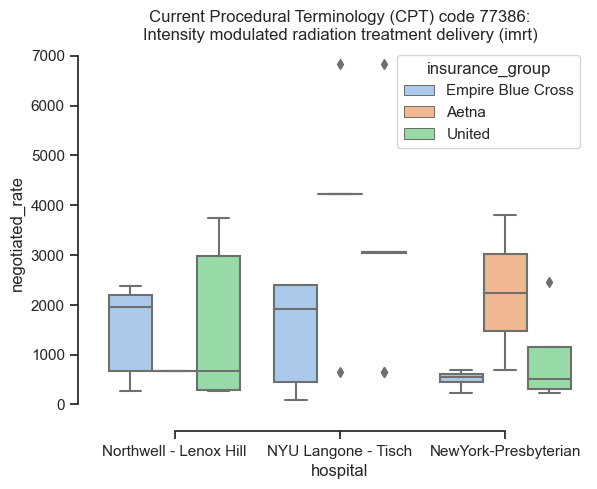

74177
hospital                insurance_group  
NYU Langone - Tisch     Empire Blue Cross    73
                        Medicare             31
                        United               15
                        Medicaid             13
                        Aetna                12
NewYork-Presbyterian    Medicaid              7
                        Medicare              6
                        Empire Blue Cross     5
                        United                4
                        Aetna                 2
Northwell - Lenox Hill  Empire Blue Cross    38
                        Aetna                24
                        Medicare              9
                        United                7
                        Medicaid              6
Name: insurance_group, dtype: int64


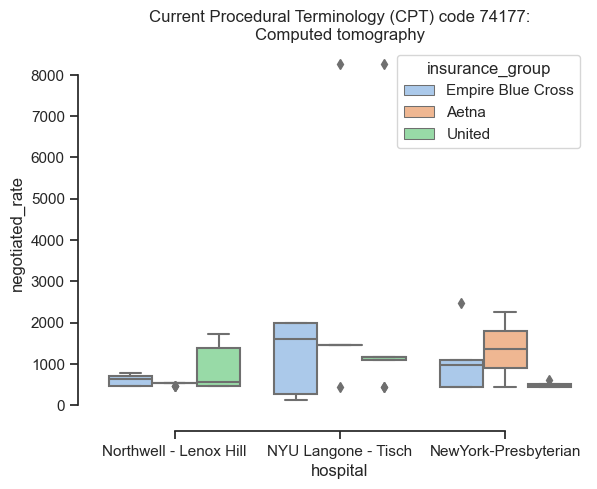

78815
hospital                insurance_group  
NYU Langone - Tisch     Empire Blue Cross    73
                        Medicare             31
                        United               15
                        Medicaid             13
                        Aetna                12
NewYork-Presbyterian    Medicaid              7
                        Medicare              6
                        Empire Blue Cross     5
                        United                4
                        Aetna                 2
Northwell - Lenox Hill  Empire Blue Cross    38
                        Aetna                24
                        Medicare              9
                        United                7
                        Medicaid              6
Name: insurance_group, dtype: int64


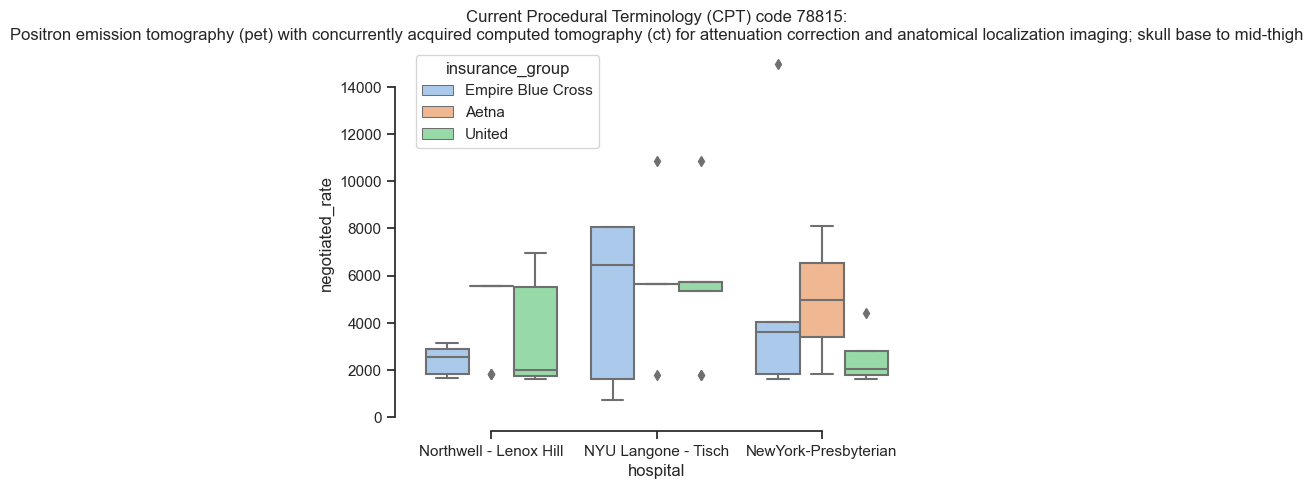

77385
hospital                insurance_group  
NYU Langone - Tisch     Empire Blue Cross    73
                        Medicare             31
                        United               15
                        Medicaid             13
                        Aetna                12
NewYork-Presbyterian    Medicaid              7
                        Medicare              6
                        Empire Blue Cross     4
                        United                4
                        Aetna                 2
Northwell - Lenox Hill  Empire Blue Cross    38
                        Medicare              9
                        United                7
                        Medicaid              6
                        Aetna                 3
Name: insurance_group, dtype: int64


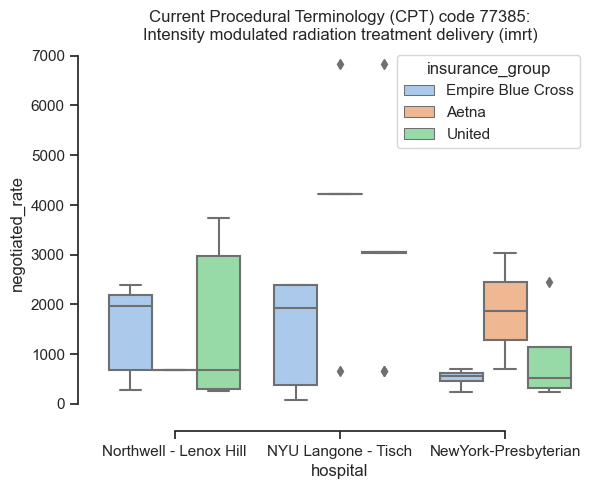

77412
hospital                insurance_group  
NYU Langone - Tisch     Empire Blue Cross    73
                        Medicare             31
                        United               15
                        Medicaid             13
                        Aetna                12
NewYork-Presbyterian    Medicaid              7
                        Medicare              6
                        Empire Blue Cross     4
                        United                4
                        Aetna                 2
Northwell - Lenox Hill  Empire Blue Cross    38
                        Medicare              9
                        United                7
                        Medicaid              6
                        Aetna                 3
Name: insurance_group, dtype: int64


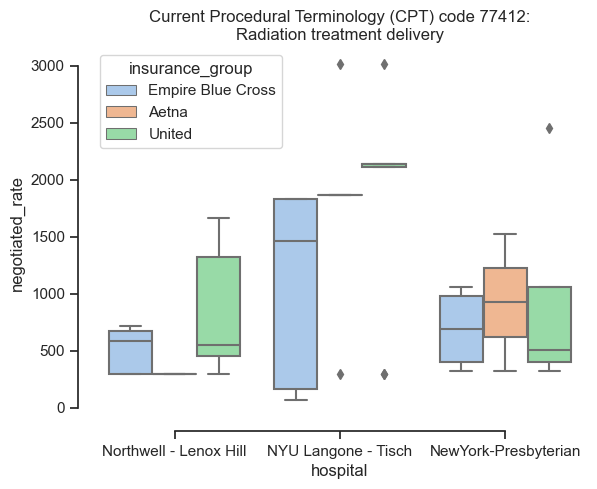

78452
hospital                insurance_group  
NYU Langone - Tisch     Empire Blue Cross    73
                        Medicare             31
                        United               15
                        Medicaid             13
                        Aetna                12
NewYork-Presbyterian    Medicaid              7
                        Medicare              6
                        Empire Blue Cross     5
                        United                4
                        Aetna                 2
Northwell - Lenox Hill  Empire Blue Cross    38
                        Aetna                24
                        Medicare              9
                        United                7
                        Medicaid              6
Name: insurance_group, dtype: int64


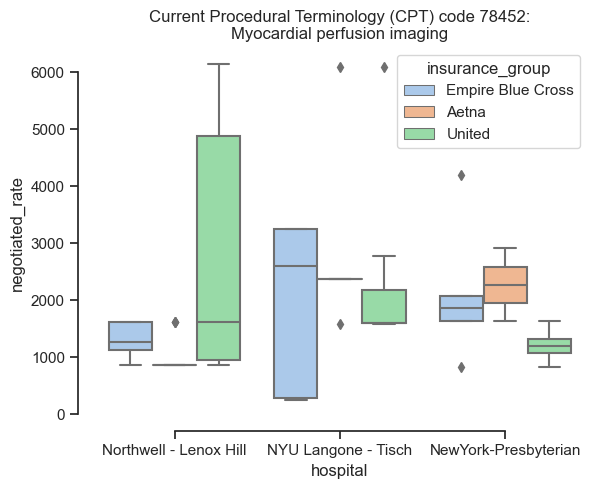

77067
hospital                insurance_group  
NYU Langone - Tisch     Empire Blue Cross    73
                        Medicare             31
                        United               15
                        Aetna                12
                        Medicaid             12
NewYork-Presbyterian    Medicaid              7
                        Medicare              6
                        Empire Blue Cross     5
                        United                4
                        Aetna                 2
Northwell - Lenox Hill  Empire Blue Cross    26
                        Aetna                21
                        United                6
                        Medicaid              5
Name: insurance_group, dtype: int64


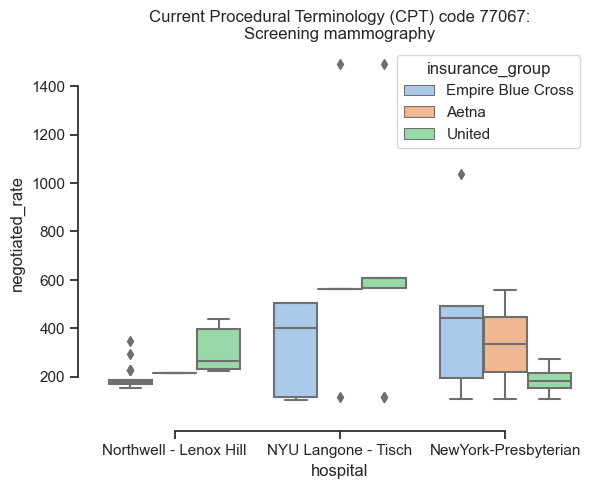

77373
hospital                insurance_group  
NYU Langone - Tisch     Empire Blue Cross    219
                        Medicare              93
                        United                45
                        Medicaid              39
                        Aetna                  6
NewYork-Presbyterian    Medicaid               7
                        Medicare               6
                        Empire Blue Cross      5
                        United                 4
                        Aetna                  2
Northwell - Lenox Hill  Empire Blue Cross     38
                        Medicare               9
                        United                 7
                        Medicaid               6
                        Aetna                  3
Name: insurance_group, dtype: int64


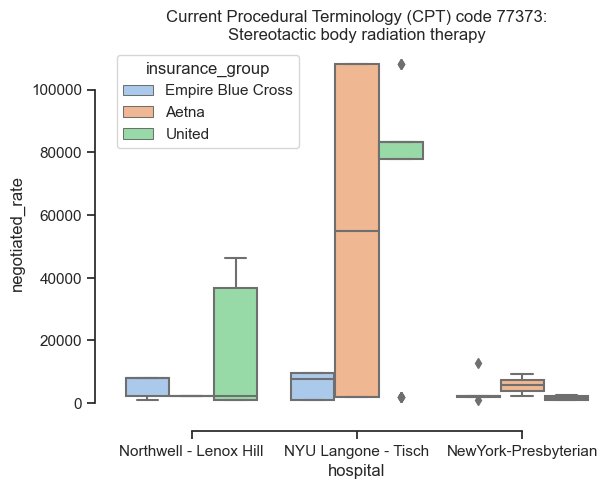

77301
hospital                insurance_group  
NYU Langone - Tisch     Empire Blue Cross    73
                        Medicare             31
                        United               15
                        Medicaid             13
                        Aetna                12
NewYork-Presbyterian    Medicaid              7
                        Medicare              6
                        Empire Blue Cross     5
                        United                4
                        Aetna                 2
Northwell - Lenox Hill  Empire Blue Cross    38
                        Aetna                24
                        Medicare              9
                        United                7
                        Medicaid              6
Name: insurance_group, dtype: int64


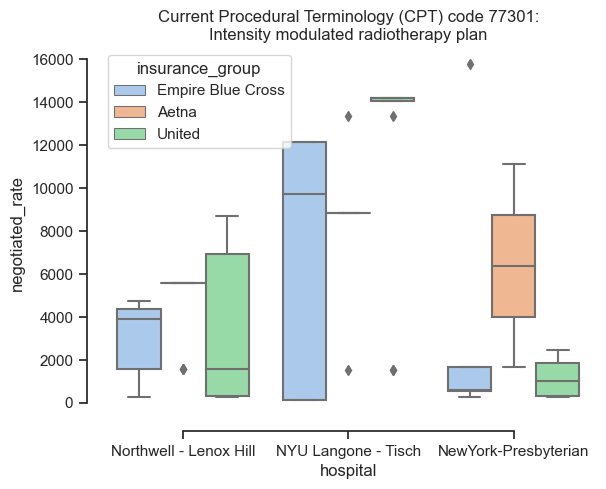

70553
hospital                insurance_group  
NYU Langone - Tisch     Empire Blue Cross    73
                        Medicare             31
                        United               15
                        Medicaid             13
                        Aetna                12
NewYork-Presbyterian    Medicaid              7
                        Medicare              6
                        Empire Blue Cross     5
                        United                4
                        Aetna                 2
Northwell - Lenox Hill  Empire Blue Cross    38
                        Aetna                24
                        Medicare              9
                        United                7
                        Medicaid              6
Name: insurance_group, dtype: int64


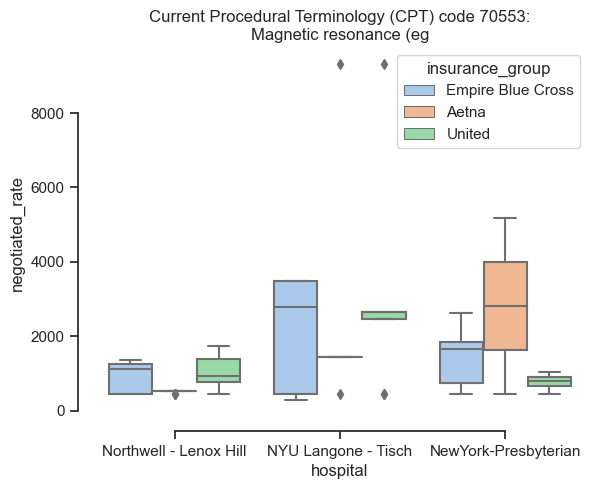

74176
hospital                insurance_group  
NYU Langone - Tisch     Empire Blue Cross    73
                        Medicare             31
                        United               15
                        Medicaid             13
                        Aetna                12
NewYork-Presbyterian    Medicaid              7
                        Medicare              6
                        Empire Blue Cross     5
                        United                4
                        Aetna                 2
Northwell - Lenox Hill  Empire Blue Cross    38
                        Aetna                24
                        Medicare              9
                        United                7
                        Medicaid              6
Name: insurance_group, dtype: int64


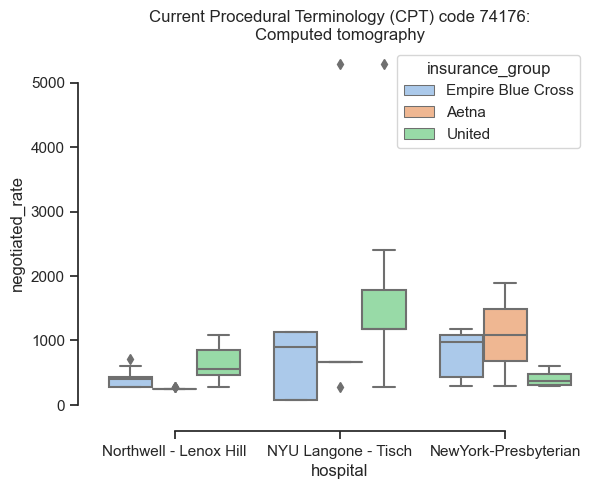

70450
hospital                insurance_group  
NYU Langone - Tisch     Empire Blue Cross    73
                        Medicare             31
                        United               15
                        Medicaid             13
                        Aetna                12
NewYork-Presbyterian    Medicaid              7
                        Medicare              6
                        Empire Blue Cross     5
                        United                4
                        Aetna                 2
Northwell - Lenox Hill  Empire Blue Cross    38
                        Aetna                24
                        Medicare              9
                        United                7
                        Medicaid              6
Name: insurance_group, dtype: int64


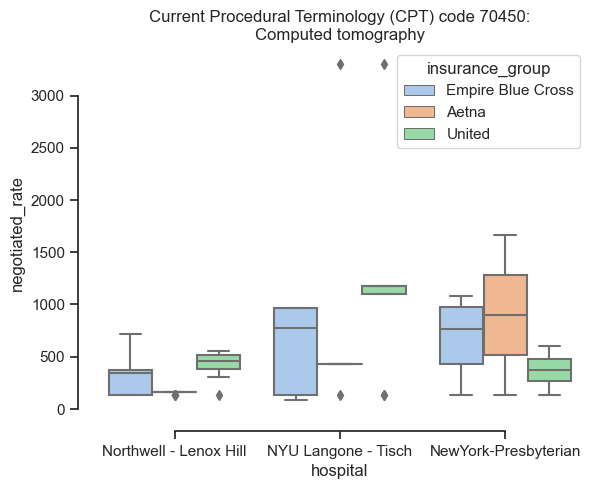

71260
hospital                insurance_group  
NYU Langone - Tisch     Empire Blue Cross    73
                        Medicare             31
                        United               15
                        Medicaid             13
                        Aetna                12
NewYork-Presbyterian    Medicaid              7
                        Medicare              6
                        Empire Blue Cross     5
                        United                4
                        Aetna                 2
Northwell - Lenox Hill  Empire Blue Cross    38
                        Aetna                24
                        Medicare              9
                        United                7
                        Medicaid              6
Name: insurance_group, dtype: int64


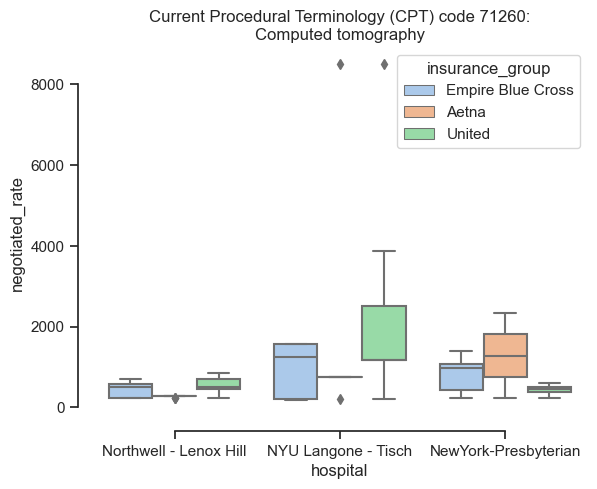

71045
hospital                insurance_group  
NYU Langone - Tisch     Empire Blue Cross    73
                        Medicare             31
                        United               15
                        Aetna                12
                        Medicaid              3
NewYork-Presbyterian    Medicaid              7
                        Medicare              6
                        Empire Blue Cross     5
                        United                4
                        Aetna                 2
Northwell - Lenox Hill  Empire Blue Cross    38
                        Aetna                24
                        Medicare              9
                        United                7
                        Medicaid              6
Name: insurance_group, dtype: int64


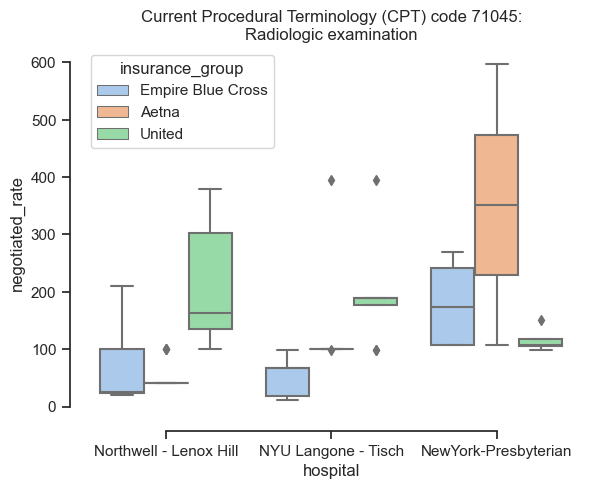

74183
hospital                insurance_group  
NYU Langone - Tisch     Empire Blue Cross    73
                        Medicare             31
                        United               15
                        Medicaid             13
                        Aetna                12
NewYork-Presbyterian    Medicaid              7
                        Medicare              6
                        Empire Blue Cross     5
                        United                4
                        Aetna                 2
Northwell - Lenox Hill  Empire Blue Cross    38
                        Aetna                24
                        Medicare              9
                        United                7
                        Medicaid              6
Name: insurance_group, dtype: int64


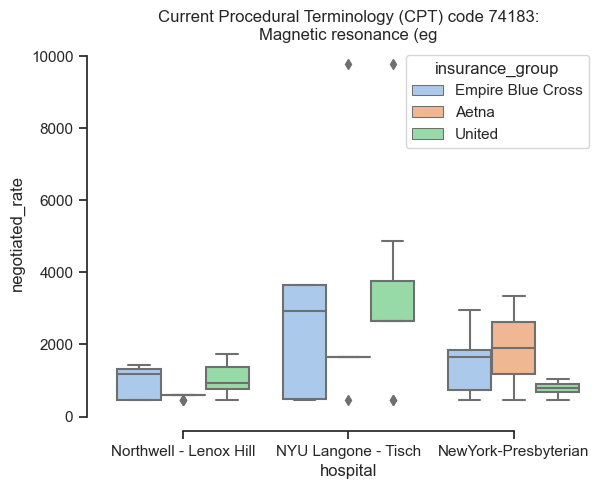

45380
hospital                insurance_group  
NYU Langone - Tisch     Empire Blue Cross    146
                        Medicare              62
                        United                29
                        Medicaid              26
                        Aetna                 23
NewYork-Presbyterian    Medicaid               7
                        Medicare               6
                        Empire Blue Cross      5
                        United                 4
                        Aetna                  2
Northwell - Lenox Hill  Empire Blue Cross     38
                        Aetna                 24
                        Medicare               9
                        United                 7
                        Medicaid               6
Name: insurance_group, dtype: int64


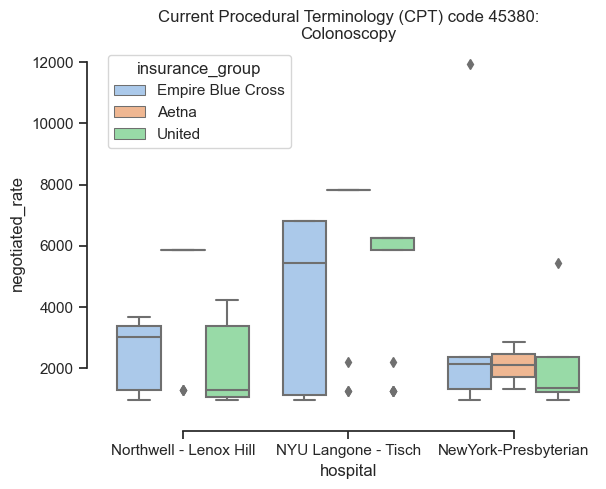

43239
hospital                insurance_group  
NYU Langone - Tisch     Empire Blue Cross    146
                        Medicare              62
                        United                29
                        Medicaid              26
                        Aetna                 23
NewYork-Presbyterian    Medicaid               7
                        Medicare               6
                        Empire Blue Cross      5
                        United                 4
                        Aetna                  2
Northwell - Lenox Hill  Empire Blue Cross     38
                        Aetna                 24
                        Medicare               9
                        United                 7
                        Medicaid               6
Name: insurance_group, dtype: int64


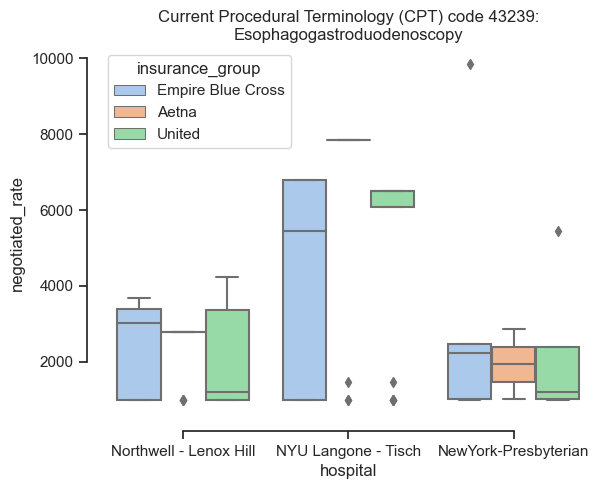

27447
hospital                insurance_group  
NYU Langone - Tisch     Empire Blue Cross    73
                        Medicare             31
                        United               14
                        Medicaid             13
                        Aetna                11
NewYork-Presbyterian    Medicaid              7
                        Medicare              6
                        Empire Blue Cross     5
                        United                4
                        Aetna                 2
Northwell - Lenox Hill  Empire Blue Cross    38
                        Aetna                24
                        Medicare              9
                        United                7
                        Medicaid              6
Name: insurance_group, dtype: int64


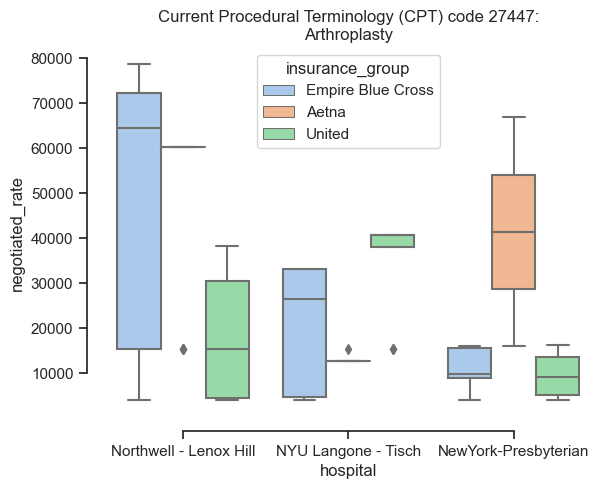

58558
hospital                insurance_group  
NYU Langone - Tisch     Empire Blue Cross    73
                        Medicare             31
                        United               14
                        Medicaid             13
                        Aetna                11
NewYork-Presbyterian    Medicaid              7
                        Medicare              6
                        Empire Blue Cross     5
                        United                4
                        Aetna                 2
Northwell - Lenox Hill  Empire Blue Cross    38
                        Aetna                24
                        Medicare              9
                        United                7
                        Medicaid              6
Name: insurance_group, dtype: int64


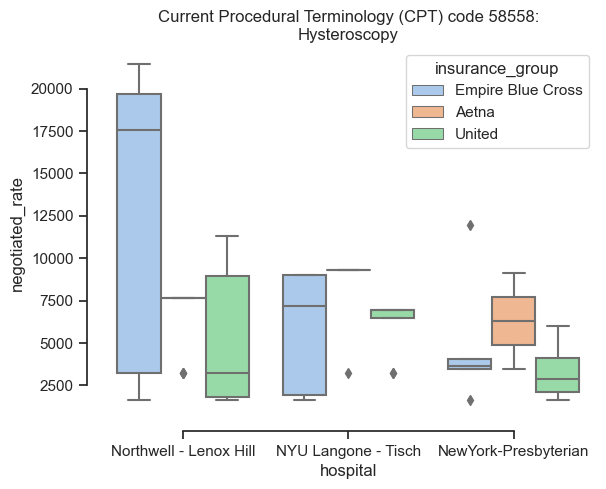

47562
hospital                insurance_group  
NYU Langone - Tisch     Empire Blue Cross    146
                        Medicare              62
                        United                29
                        Medicaid              26
                        Aetna                 23
NewYork-Presbyterian    Medicaid               7
                        Medicare               6
                        Empire Blue Cross      5
                        United                 4
                        Aetna                  2
Northwell - Lenox Hill  Empire Blue Cross     38
                        Aetna                 24
                        Medicare               9
                        United                 7
                        Medicaid               6
Name: insurance_group, dtype: int64


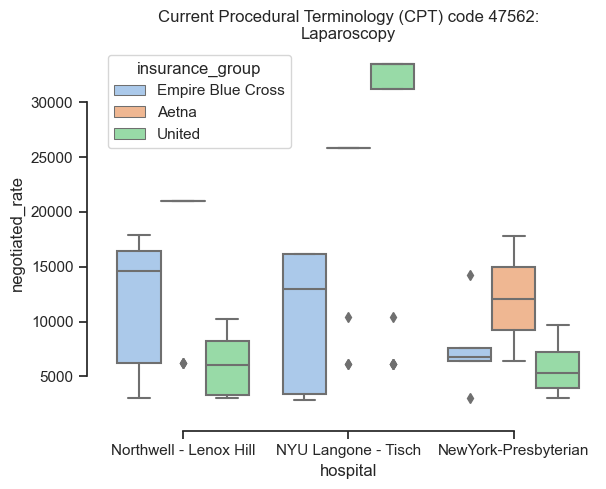

45385
hospital                insurance_group  
NYU Langone - Tisch     Empire Blue Cross    146
                        Medicare              62
                        United                29
                        Medicaid              26
                        Aetna                 23
NewYork-Presbyterian    Medicaid               7
                        Medicare               6
                        Empire Blue Cross      5
                        United                 4
                        Aetna                  2
Northwell - Lenox Hill  Empire Blue Cross     38
                        Aetna                 24
                        Medicare               9
                        United                 7
                        Medicaid               6
Name: insurance_group, dtype: int64


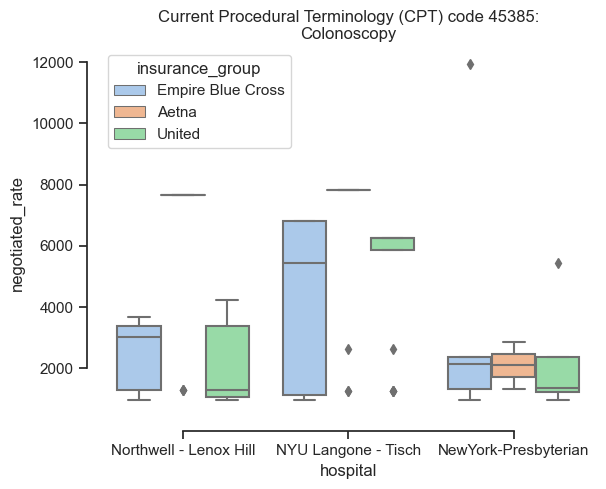

49650
hospital                insurance_group  
NYU Langone - Tisch     Empire Blue Cross    73
                        Medicare             31
                        United               14
                        Medicaid             13
                        Aetna                11
NewYork-Presbyterian    Medicaid              7
                        Medicare              6
                        Empire Blue Cross     5
                        United                4
                        Aetna                 2
Northwell - Lenox Hill  Empire Blue Cross    38
                        Aetna                24
                        Medicare              9
                        United                7
                        Medicaid              6
Name: insurance_group, dtype: int64


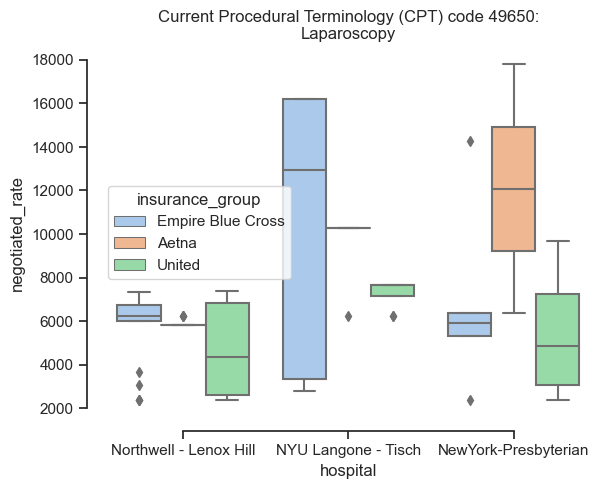

44970
hospital                insurance_group  
NYU Langone - Tisch     Empire Blue Cross    146
                        Medicare              62
                        United                28
                        Medicaid              26
                        Aetna                 22
NewYork-Presbyterian    Medicaid               7
                        Medicare               6
                        Empire Blue Cross      5
                        United                 4
                        Aetna                  2
Northwell - Lenox Hill  Empire Blue Cross     38
                        Aetna                 24
                        Medicare               9
                        United                 7
                        Medicaid               6
Name: insurance_group, dtype: int64


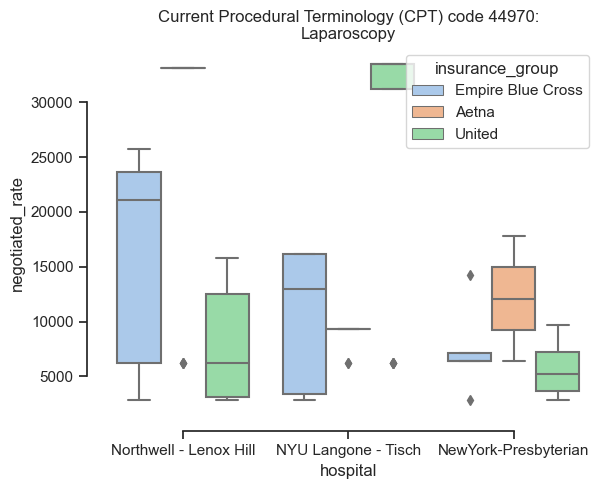

45378
hospital                insurance_group  
NYU Langone - Tisch     Empire Blue Cross    146
                        Medicare              62
                        United                29
                        Medicaid              26
                        Aetna                 23
NewYork-Presbyterian    Medicaid               7
                        Medicare               6
                        Empire Blue Cross      5
                        United                 4
                        Aetna                  2
Northwell - Lenox Hill  Empire Blue Cross     38
                        Aetna                 24
                        Medicare               9
                        United                 7
                        Medicaid               6
Name: insurance_group, dtype: int64


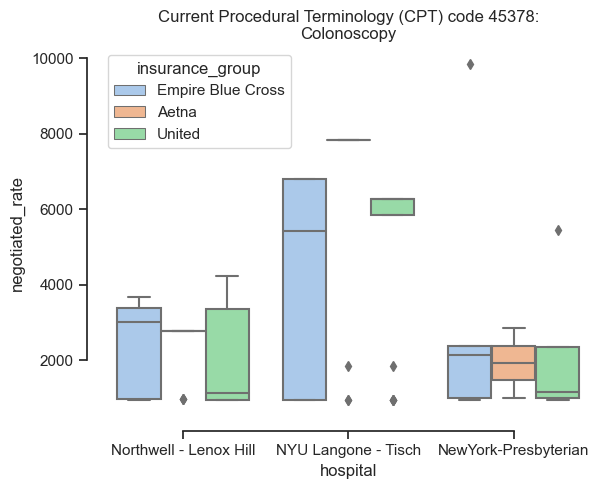

36430
58571
hospital                insurance_group  
NYU Langone - Tisch     Empire Blue Cross    146
                        Medicare              62
                        United                29
                        Medicaid              26
                        Aetna                 23
NewYork-Presbyterian    Medicaid               7
                        Medicare               6
                        Empire Blue Cross      5
                        United                 4
                        Aetna                  2
Northwell - Lenox Hill  Empire Blue Cross     38
                        Aetna                 24
                        Medicare               9
                        United                 7
                        Medicaid               6
Name: insurance_group, dtype: int64


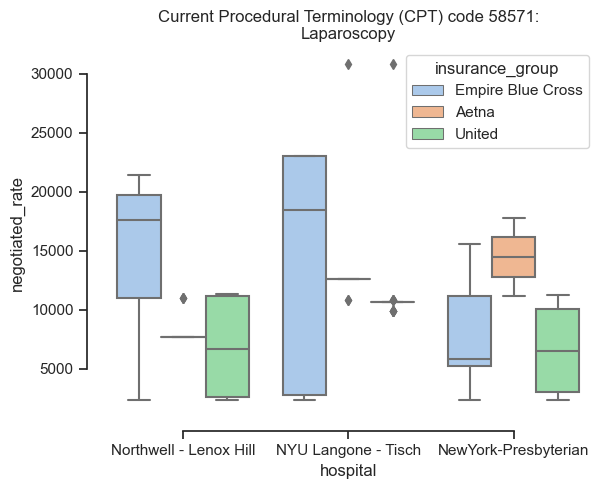

52356
hospital                insurance_group  
NYU Langone - Tisch     Empire Blue Cross    73
                        Medicare             31
                        United               14
                        Medicaid             13
                        Aetna                11
NewYork-Presbyterian    Medicaid              7
                        Medicare              6
                        Empire Blue Cross     5
                        United                4
                        Aetna                 2
Northwell - Lenox Hill  Empire Blue Cross    38
                        Aetna                24
                        Medicare              9
                        United                7
                        Medicaid              6
Name: insurance_group, dtype: int64


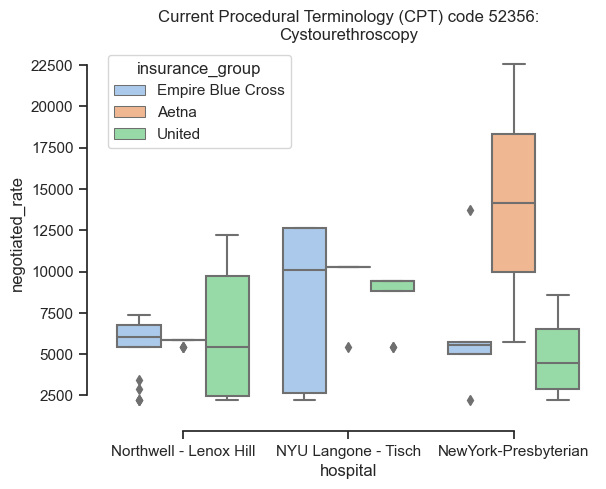

66984
hospital                insurance_group  
NYU Langone - Tisch     Empire Blue Cross    73
                        Medicare             31
                        United               14
                        Medicaid             13
                        Aetna                11
NewYork-Presbyterian    Medicaid              7
                        Medicare              6
                        Empire Blue Cross     5
                        United                4
                        Aetna                 2
Northwell - Lenox Hill  Empire Blue Cross    38
                        Aetna                24
                        Medicare              9
                        United                7
                        Medicaid              6
Name: insurance_group, dtype: int64


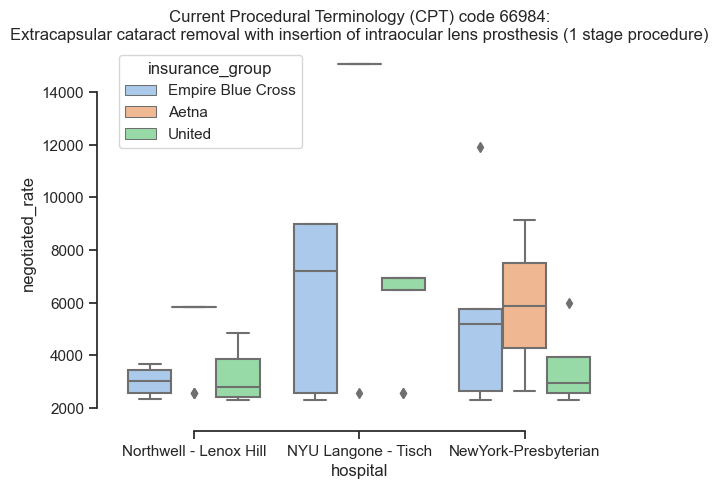

27130
hospital                insurance_group  
NYU Langone - Tisch     Empire Blue Cross    73
                        Medicare             31
                        United               14
                        Medicaid             13
                        Aetna                11
NewYork-Presbyterian    Medicaid              7
                        Medicare              6
                        Empire Blue Cross     5
                        United                4
                        Aetna                 2
Northwell - Lenox Hill  Empire Blue Cross    38
                        Aetna                24
                        Medicare              9
                        United                7
                        Medicaid              6
Name: insurance_group, dtype: int64


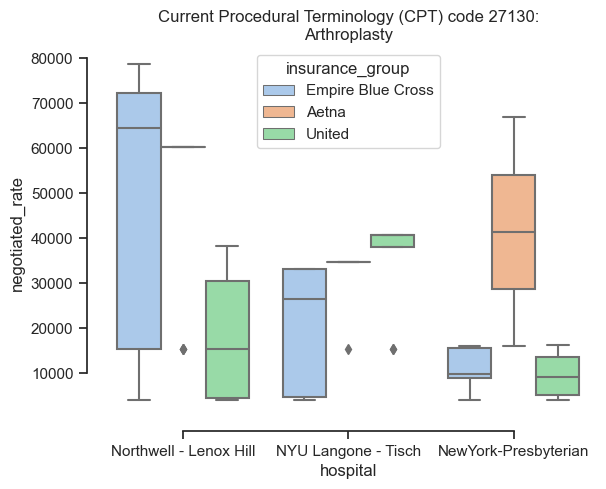

36000


In [100]:
for billing_code in df_top_cpt_codes_cost['billing_code']:
    print(billing_code)
    if billing_code in df['billing_code'].values:
      print(df[df['billing_code'] == billing_code].groupby('hospital').insurance_group.value_counts())
      sns.boxplot(x="hospital", y="negotiated_rate",
            hue="insurance_group", 
            hue_order=["Empire Blue Cross", "Aetna", "United"],
            #palette=["m", "g"],
            data=df[df['billing_code'] == billing_code]).set(title=f"Current Procedural Terminology (CPT) code {billing_code}:\n{billing_code_to_description[billing_code].split(',')[0].lower().capitalize()}")
      sns.despine(offset=10, trim=True)
      plt.show()
      

# Plot estimated spend


In [101]:
df['estimated_spend'] = df['negotiated_rate'] * df['count']

In [106]:
import matplotlib.ticker as ticker

# Create a custom formatter function
def format_ticks(value, pos):
    if value >= 1e6:
        return f'{value*1e-6:.0f}M'
    elif value >= 1e3:
        return f'{value*1e-3:.0f}K'
    else:
        return f'{value}'

# Create a FuncFormatter object
formatter = ticker.FuncFormatter(format_ticks)

99284
hospital                insurance_group  
NYU Langone - Tisch     Empire Blue Cross    122
                        Medicare              62
                        United                30
                        Aetna                 24
                        Medicaid               6
NewYork-Presbyterian    Medicare               6
                        Aetna                  2
                        Empire Blue Cross      2
                        United                 2
Northwell - Lenox Hill  Empire Blue Cross     33
                        Aetna                 24
                        Medicare               9
                        United                 4
                        Medicaid               1
Name: insurance_group, dtype: int64


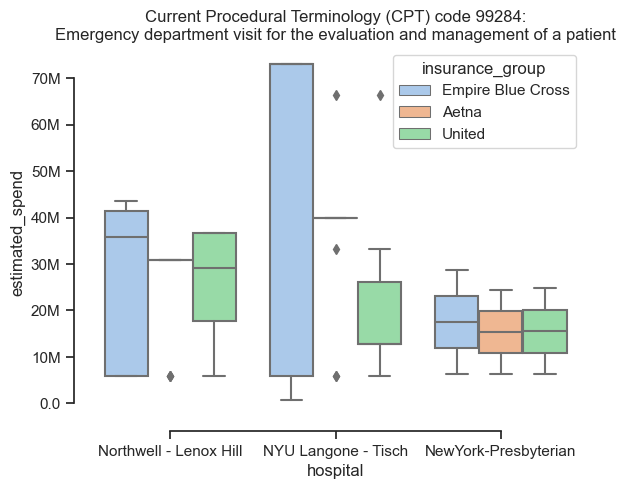

99285
hospital                insurance_group  
NYU Langone - Tisch     Empire Blue Cross    122
                        Medicare              62
                        United                30
                        Aetna                 24
                        Medicaid               6
NewYork-Presbyterian    Medicare               6
                        Aetna                  2
                        Empire Blue Cross      2
                        United                 2
Northwell - Lenox Hill  Empire Blue Cross     33
                        Aetna                 24
                        Medicare               9
                        United                 4
                        Medicaid               1
Name: insurance_group, dtype: int64


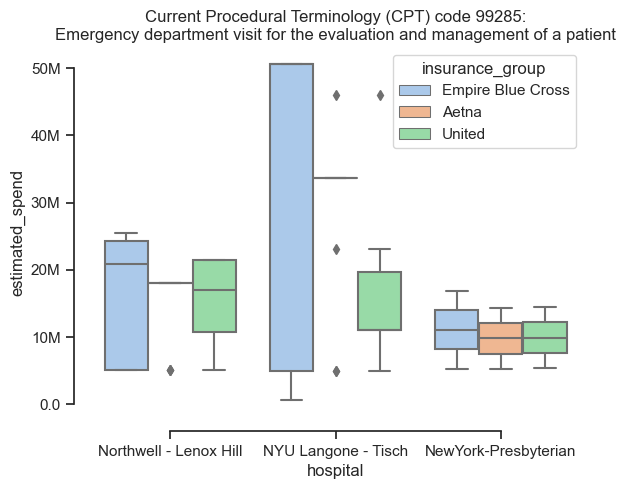

99283
hospital                insurance_group  
NYU Langone - Tisch     Empire Blue Cross    122
                        Medicare              62
                        United                30
                        Aetna                 24
                        Medicaid               6
NewYork-Presbyterian    Medicare               6
                        Aetna                  2
                        Empire Blue Cross      2
                        United                 2
Northwell - Lenox Hill  Empire Blue Cross     33
                        Aetna                 24
                        Medicare               9
                        United                 4
                        Medicaid               1
Name: insurance_group, dtype: int64


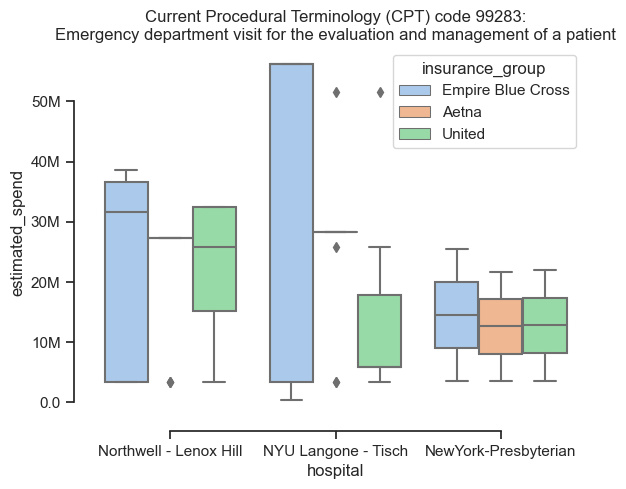

99282
hospital                insurance_group  
NYU Langone - Tisch     Empire Blue Cross    122
                        Medicare              62
                        United                30
                        Aetna                 24
                        Medicaid               6
NewYork-Presbyterian    Medicare               6
                        Aetna                  2
                        Empire Blue Cross      2
                        United                 2
Northwell - Lenox Hill  Empire Blue Cross     33
                        Aetna                 24
                        Medicare               9
                        United                 4
                        Medicaid               1
Name: insurance_group, dtype: int64


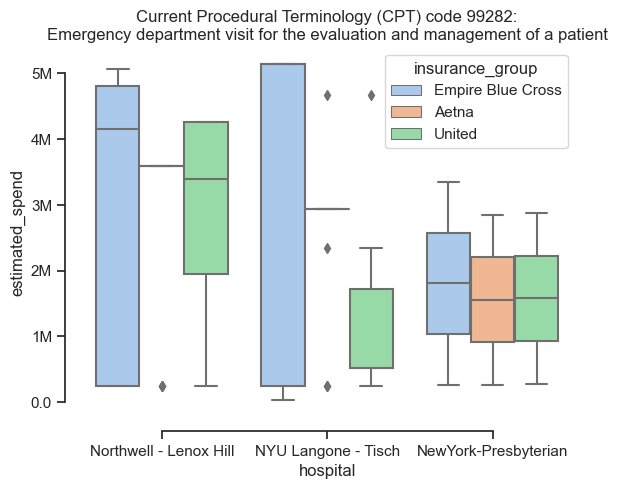

99214
99281
hospital                insurance_group  
NYU Langone - Tisch     Empire Blue Cross    244
                        Medicare             124
                        United                60
                        Aetna                 48
                        Medicaid              12
NewYork-Presbyterian    Medicare               6
                        Aetna                  2
                        Empire Blue Cross      2
                        United                 2
Northwell - Lenox Hill  Empire Blue Cross     33
                        Aetna                 24
                        Medicare               9
                        United                 4
                        Medicaid               1
Name: insurance_group, dtype: int64


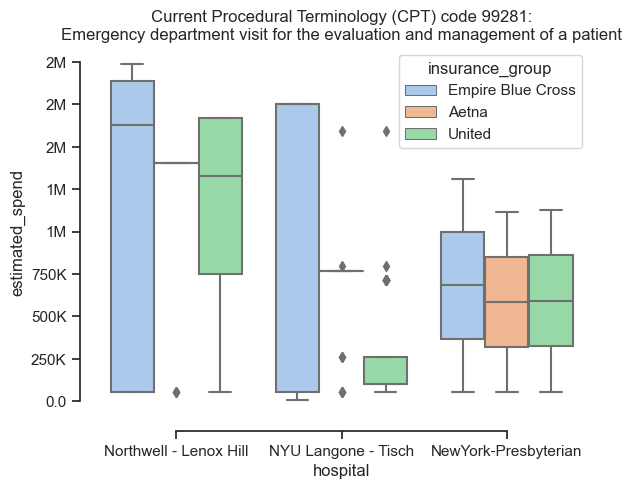

99291
99213
99218
99219
99212
99215
99203
99220
99211
96413
93458
hospital                insurance_group  
NYU Langone - Tisch     Empire Blue Cross    146
                        Medicare              62
                        United                29
                        Medicaid              26
                        Aetna                 23
NewYork-Presbyterian    Medicaid               7
                        Medicare               6
                        Empire Blue Cross      5
                        United                 4
                        Aetna                  2
Northwell - Lenox Hill  Empire Blue Cross     38
                        Aetna                 24
                        Medicare               9
                        United                 7
                        Medicaid               6
Name: insurance_group, dtype: int64


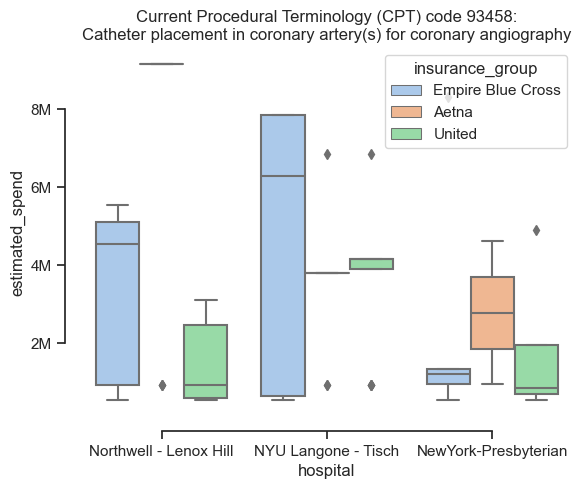

96374
96365
96372
93306
96375
93454
hospital                insurance_group  
NYU Langone - Tisch     Empire Blue Cross    146
                        Medicare              62
                        United                29
                        Medicaid              26
                        Aetna                 23
NewYork-Presbyterian    Medicaid               7
                        Medicare               6
                        Empire Blue Cross      5
                        United                 4
                        Aetna                  2
Northwell - Lenox Hill  Empire Blue Cross     38
                        Aetna                 24
                        Medicare               9
                        United                 7
                        Medicaid               6
Name: insurance_group, dtype: int64


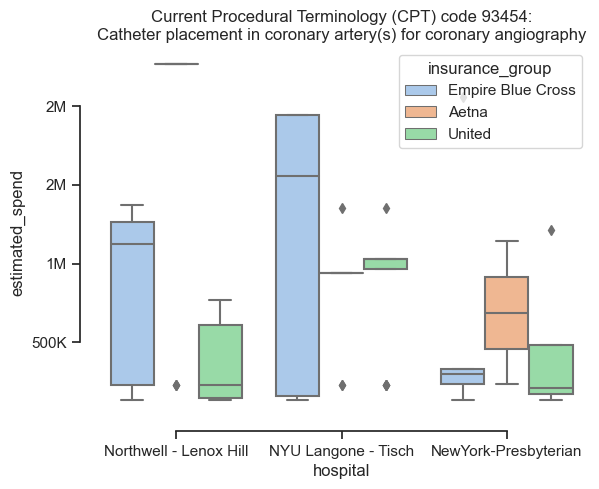

96361
90832
hospital                insurance_group  
NYU Langone - Tisch     Empire Blue Cross    511
                        Medicare             217
                        United               105
                        Medicaid              91
                        Aetna                 84
NewYork-Presbyterian    Medicaid               7
                        Medicare               6
                        Empire Blue Cross      5
                        United                 4
                        Aetna                  2
Northwell - Lenox Hill  Empire Blue Cross     38
                        Aetna                 24
                        Medicare               9
                        Medicaid               6
                        United                 4
Name: insurance_group, dtype: int64


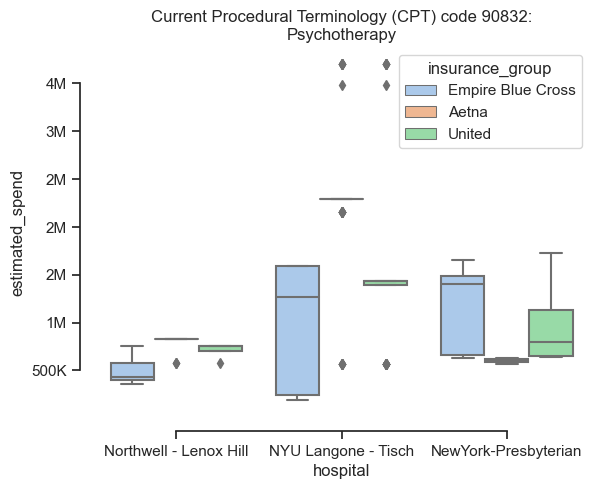

93005
hospital                insurance_group  
NYU Langone - Tisch     Empire Blue Cross    146
                        Medicare              62
                        United                30
                        Aetna                 24
                        Medicaid               6
NewYork-Presbyterian    Medicaid               7
                        Medicare               6
                        Empire Blue Cross      5
                        United                 4
                        Aetna                  2
Northwell - Lenox Hill  Empire Blue Cross     38
                        Aetna                 24
                        Medicare               9
                        United                 7
                        Medicaid               6
Name: insurance_group, dtype: int64


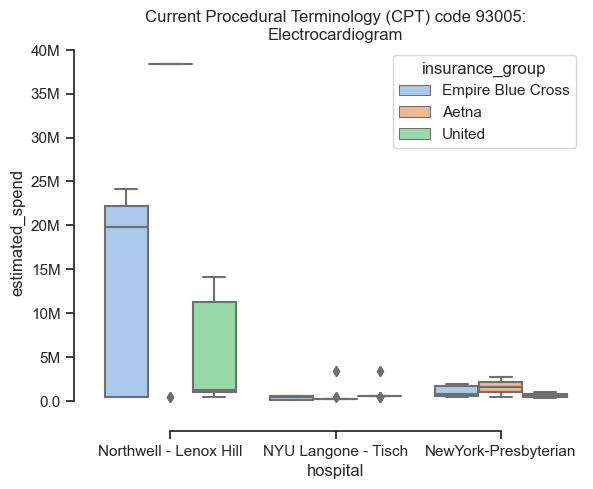

92978
hospital                insurance_group  
NYU Langone - Tisch     Empire Blue Cross    42
                        United               25
                        Medicaid             24
                        Aetna                21
NewYork-Presbyterian    Medicaid              7
                        Empire Blue Cross     4
                        United                3
                        Aetna                 1
Northwell - Lenox Hill  Empire Blue Cross    26
                        Aetna                21
                        United                6
                        Medicaid              5
Name: insurance_group, dtype: int64


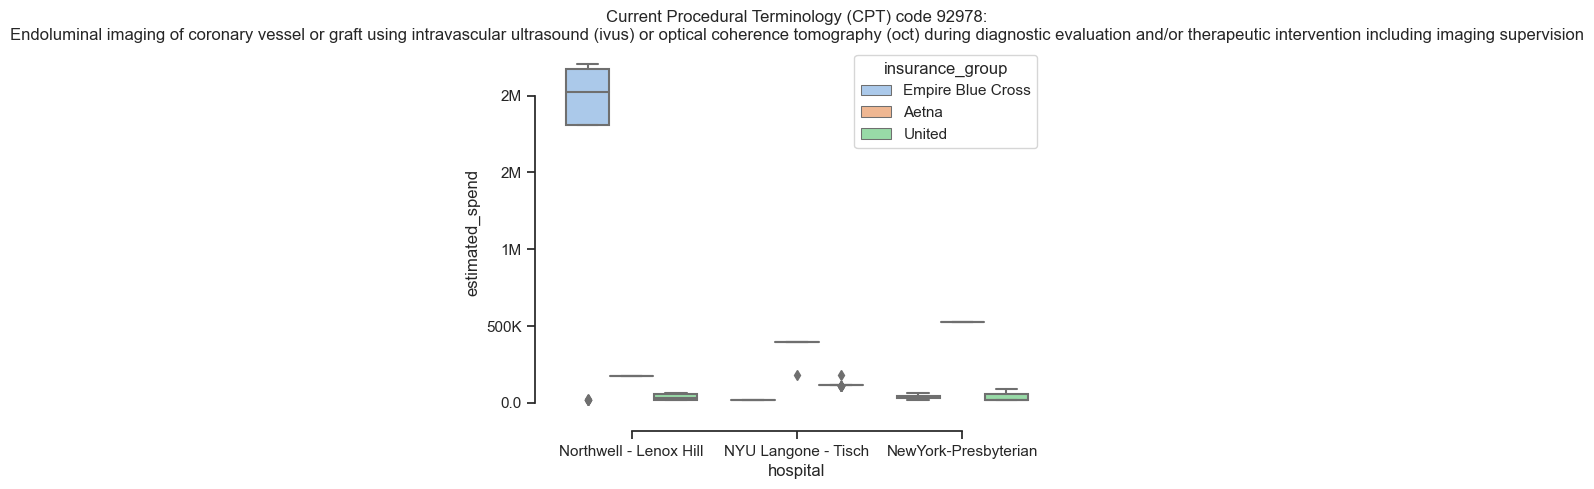

96360
96402
90834
hospital                insurance_group  
NYU Langone - Tisch     Empire Blue Cross    511
                        Medicare             217
                        United               105
                        Medicaid              91
                        Aetna                 84
NewYork-Presbyterian    Medicaid               7
                        Medicare               6
                        Empire Blue Cross      5
                        United                 4
                        Aetna                  2
Northwell - Lenox Hill  Empire Blue Cross     38
                        Aetna                 24
                        Medicare               9
                        Medicaid               6
                        United                 4
Name: insurance_group, dtype: int64


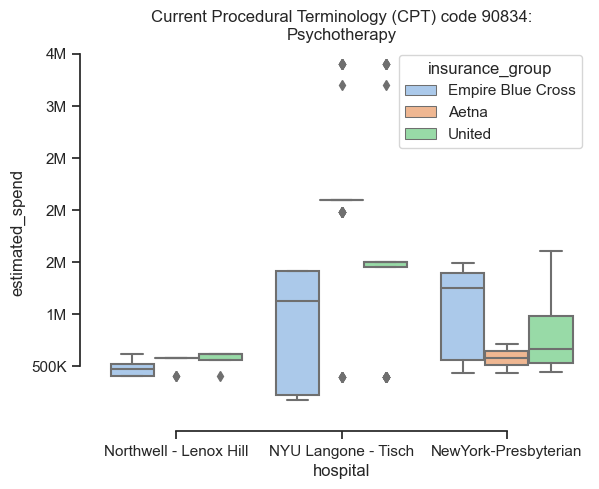

80053
hospital                insurance_group  
NYU Langone - Tisch     Empire Blue Cross    51
                        United               13
                        Medicaid             12
                        Aetna                11
                        Medicare              5
NewYork-Presbyterian    Medicaid              7
                        Medicare              6
                        Empire Blue Cross     5
                        United                4
                        Aetna                 2
Northwell - Lenox Hill  Empire Blue Cross    38
                        Aetna                24
                        Medicare              9
                        United                7
                        Medicaid              6
Name: insurance_group, dtype: int64


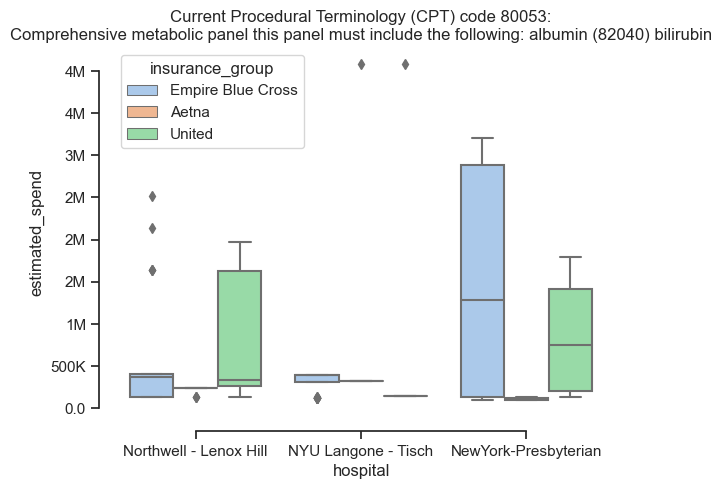

88305
85025
hospital                insurance_group  
NYU Langone - Tisch     Empire Blue Cross    64
                        United               13
                        Aetna                11
                        Medicare              5
                        Medicaid              2
NewYork-Presbyterian    Medicaid              7
                        Medicare              6
                        Empire Blue Cross     5
                        United                4
                        Aetna                 2
Northwell - Lenox Hill  Empire Blue Cross    38
                        Aetna                24
                        Medicare              9
                        United                7
                        Medicaid              6
Name: insurance_group, dtype: int64


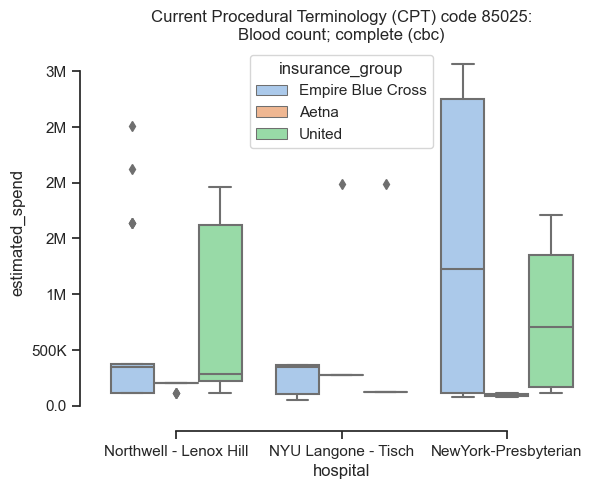

88185
80048
hospital                insurance_group  
NYU Langone - Tisch     Empire Blue Cross    51
                        United               13
                        Medicaid             12
                        Aetna                11
                        Medicare              5
NewYork-Presbyterian    Medicaid              7
                        Medicare              6
                        Empire Blue Cross     5
                        United                4
                        Aetna                 2
Northwell - Lenox Hill  Empire Blue Cross    38
                        Aetna                24
                        Medicare              9
                        United                7
                        Medicaid              6
Name: insurance_group, dtype: int64


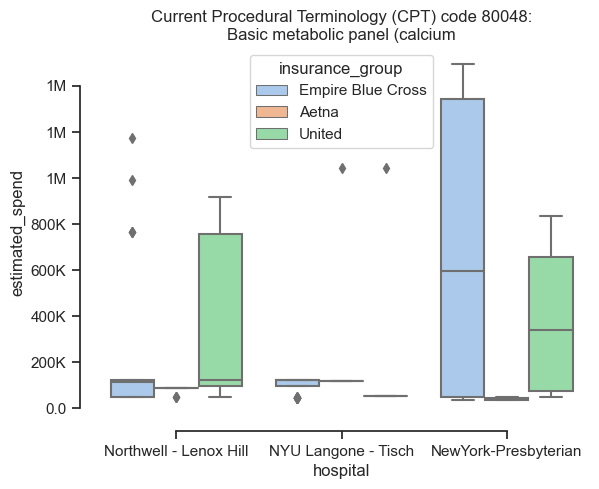

80061
hospital                insurance_group  
NYU Langone - Tisch     Empire Blue Cross    60
                        Medicare             31
                        United               15
                        Medicaid             13
                        Aetna                12
NewYork-Presbyterian    Medicaid              7
                        Medicare              6
                        Empire Blue Cross     5
                        United                4
                        Aetna                 2
Northwell - Lenox Hill  Empire Blue Cross    38
                        Aetna                24
                        Medicare              9
                        United                7
                        Medicaid              6
Name: insurance_group, dtype: int64


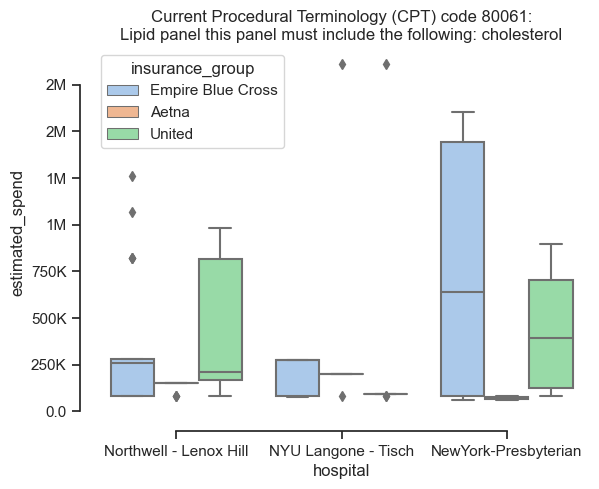

84443
hospital                insurance_group  
NYU Langone - Tisch     Empire Blue Cross    51
                        United               13
                        Aetna                11
                        Medicare              5
                        Medicaid              2
NewYork-Presbyterian    Medicaid              7
                        Medicare              6
                        Empire Blue Cross     5
                        United                4
                        Aetna                 2
Northwell - Lenox Hill  Empire Blue Cross    38
                        Aetna                24
                        Medicare              9
                        United                7
                        Medicaid              6
Name: insurance_group, dtype: int64


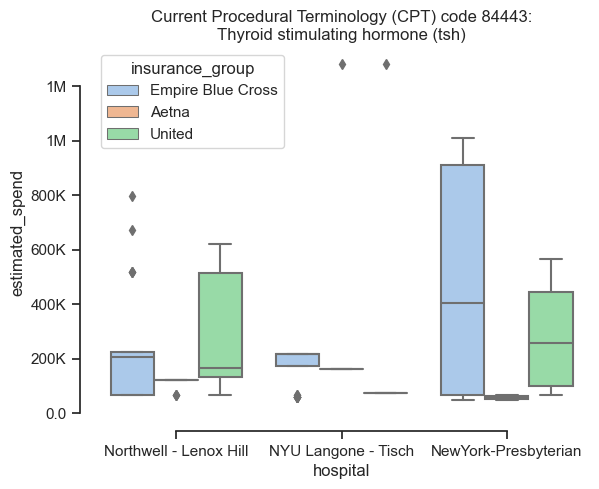

87491
hospital                insurance_group  
NYU Langone - Tisch     Empire Blue Cross    51
                        United               13
                        Medicaid             12
                        Aetna                11
                        Medicare              5
NewYork-Presbyterian    Medicaid              7
                        Medicare              6
                        Empire Blue Cross     5
                        United                4
                        Aetna                 2
Northwell - Lenox Hill  Empire Blue Cross    38
                        Aetna                24
                        Medicare              9
                        United                7
                        Medicaid              6
Name: insurance_group, dtype: int64


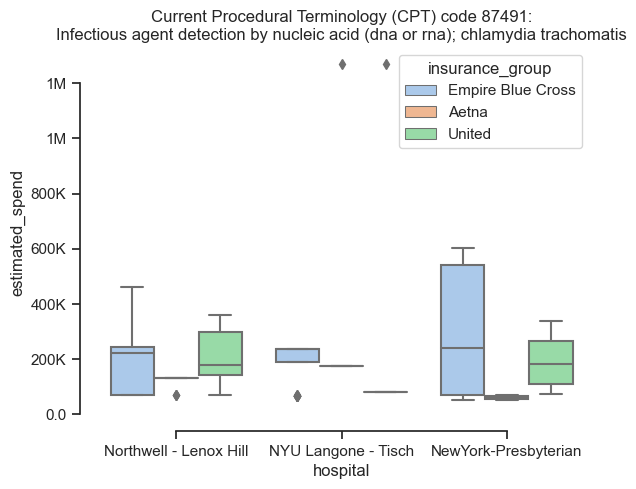

82306
hospital                insurance_group  
NYU Langone - Tisch     Empire Blue Cross    51
                        United               13
                        Medicaid             12
                        Aetna                11
                        Medicare              5
NewYork-Presbyterian    Medicaid              7
                        Medicare              6
                        Empire Blue Cross     5
                        United                4
                        Aetna                 2
Northwell - Lenox Hill  Empire Blue Cross    38
                        Aetna                24
                        Medicare              9
                        United                7
                        Medicaid              6
Name: insurance_group, dtype: int64


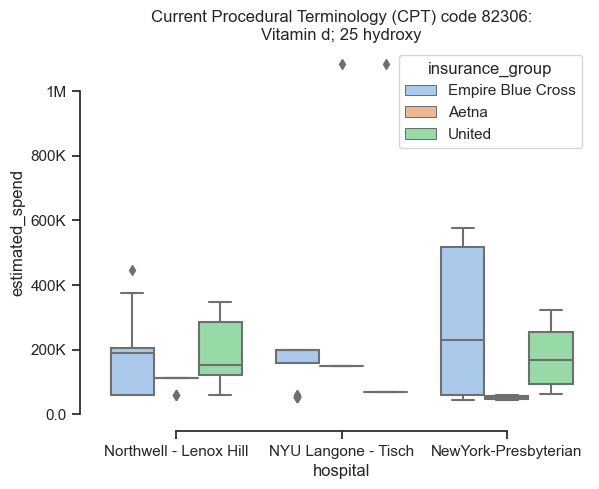

87591
hospital                insurance_group  
NYU Langone - Tisch     Empire Blue Cross    51
                        United               13
                        Medicaid             12
                        Aetna                11
                        Medicare              5
NewYork-Presbyterian    Medicaid              7
                        Medicare              6
                        Empire Blue Cross     5
                        United                4
                        Aetna                 2
Northwell - Lenox Hill  Empire Blue Cross    38
                        Aetna                24
                        Medicare              9
                        United                7
                        Medicaid              6
Name: insurance_group, dtype: int64


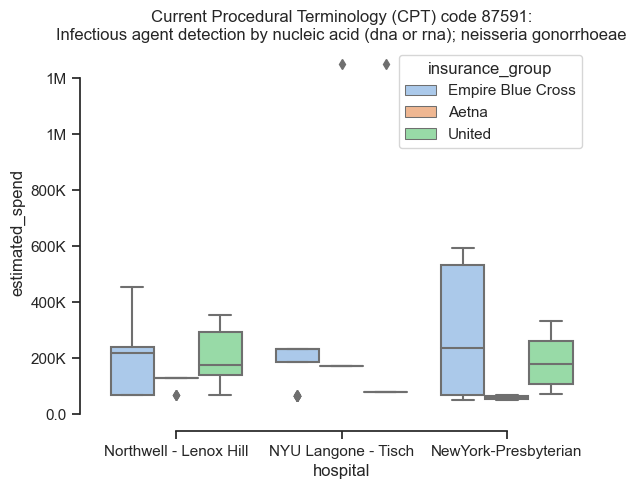

84484
hospital                insurance_group  
NYU Langone - Tisch     Empire Blue Cross    51
                        United               13
                        Aetna                11
                        Medicare              5
                        Medicaid              2
NewYork-Presbyterian    Medicaid              7
                        Medicare              6
                        Empire Blue Cross     5
                        United                4
                        Aetna                 2
Northwell - Lenox Hill  Empire Blue Cross    38
                        Aetna                24
                        Medicare              9
                        United                7
                        Medicaid              6
Name: insurance_group, dtype: int64


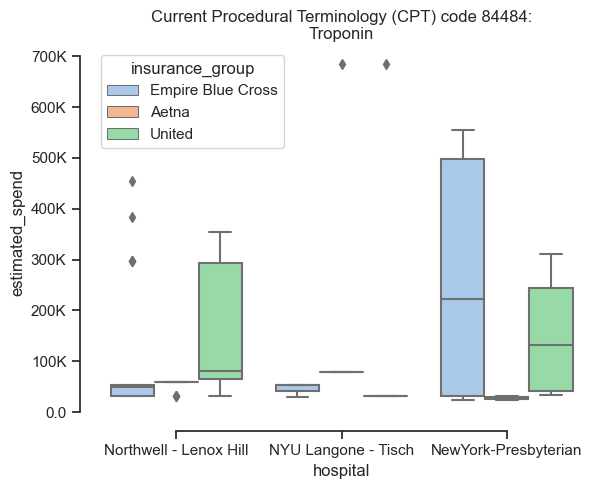

87636
83036
hospital                insurance_group  
NYU Langone - Tisch     Empire Blue Cross    51
                        United               13
                        Aetna                11
                        Medicare              5
                        Medicaid              2
NewYork-Presbyterian    Medicaid              7
                        Medicare              6
                        Empire Blue Cross     5
                        United                4
                        Aetna                 2
Northwell - Lenox Hill  Empire Blue Cross    38
                        Aetna                24
                        Medicare              9
                        United                7
                        Medicaid              6
Name: insurance_group, dtype: int64


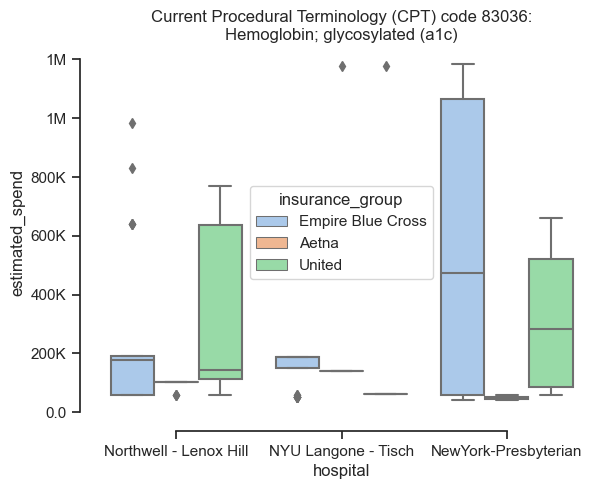

81408
hospital                insurance_group  
NYU Langone - Tisch     Medicare             31
                        United               15
                        Aetna                12
                        Empire Blue Cross    11
                        Medicaid              2
NewYork-Presbyterian    Medicare              6
                        Aetna                 2
                        Empire Blue Cross     2
                        United                2
Northwell - Lenox Hill  Empire Blue Cross    33
                        Aetna                24
                        Medicare              9
                        United                4
                        Medicaid              1
Name: insurance_group, dtype: int64


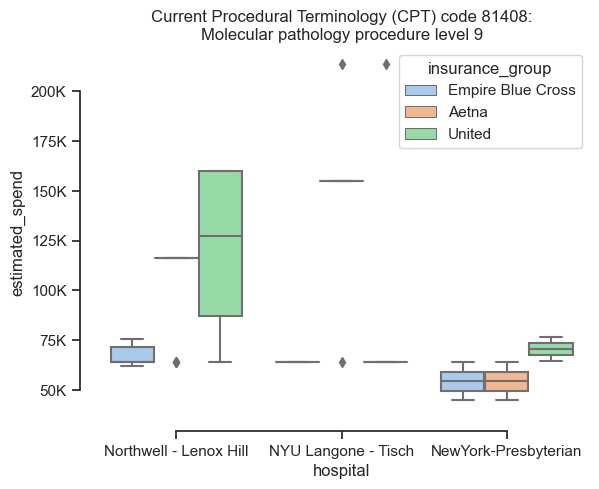

87635
77386
hospital                insurance_group  
NYU Langone - Tisch     Empire Blue Cross    73
                        Medicare             31
                        United               15
                        Medicaid             13
                        Aetna                12
NewYork-Presbyterian    Medicaid              7
                        Medicare              6
                        Empire Blue Cross     4
                        United                4
                        Aetna                 2
Northwell - Lenox Hill  Empire Blue Cross    38
                        Medicare              9
                        United                7
                        Medicaid              6
                        Aetna                 3
Name: insurance_group, dtype: int64


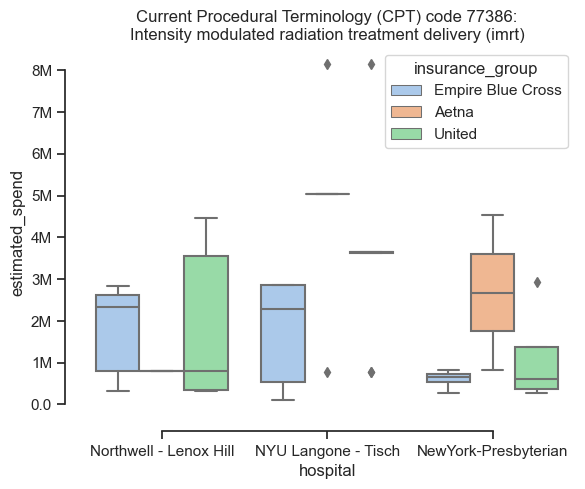

74177
hospital                insurance_group  
NYU Langone - Tisch     Empire Blue Cross    73
                        Medicare             31
                        United               15
                        Medicaid             13
                        Aetna                12
NewYork-Presbyterian    Medicaid              7
                        Medicare              6
                        Empire Blue Cross     5
                        United                4
                        Aetna                 2
Northwell - Lenox Hill  Empire Blue Cross    38
                        Aetna                24
                        Medicare              9
                        United                7
                        Medicaid              6
Name: insurance_group, dtype: int64


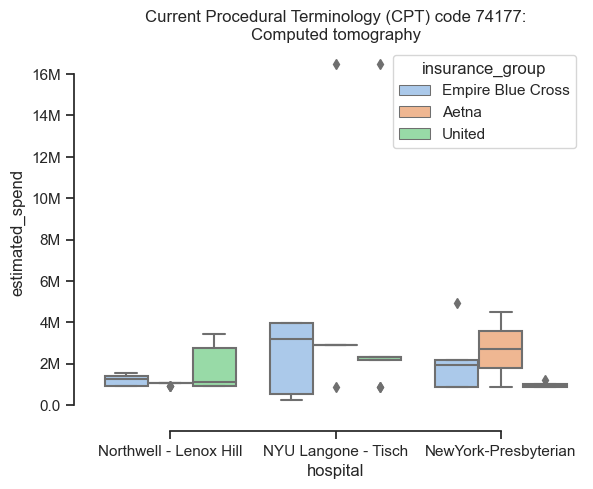

78815
hospital                insurance_group  
NYU Langone - Tisch     Empire Blue Cross    73
                        Medicare             31
                        United               15
                        Medicaid             13
                        Aetna                12
NewYork-Presbyterian    Medicaid              7
                        Medicare              6
                        Empire Blue Cross     5
                        United                4
                        Aetna                 2
Northwell - Lenox Hill  Empire Blue Cross    38
                        Aetna                24
                        Medicare              9
                        United                7
                        Medicaid              6
Name: insurance_group, dtype: int64


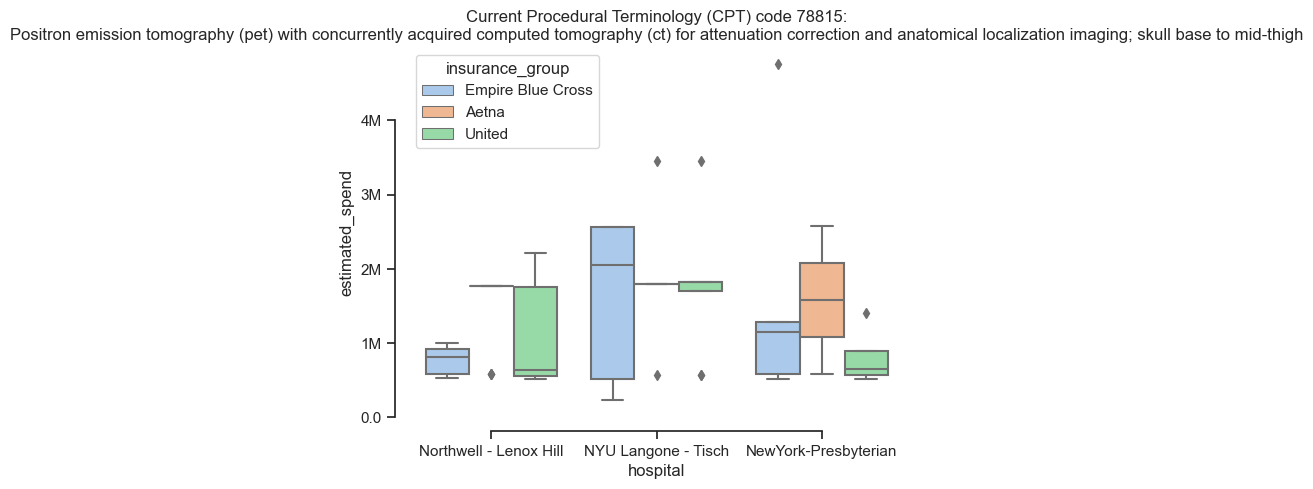

77385
hospital                insurance_group  
NYU Langone - Tisch     Empire Blue Cross    73
                        Medicare             31
                        United               15
                        Medicaid             13
                        Aetna                12
NewYork-Presbyterian    Medicaid              7
                        Medicare              6
                        Empire Blue Cross     4
                        United                4
                        Aetna                 2
Northwell - Lenox Hill  Empire Blue Cross    38
                        Medicare              9
                        United                7
                        Medicaid              6
                        Aetna                 3
Name: insurance_group, dtype: int64


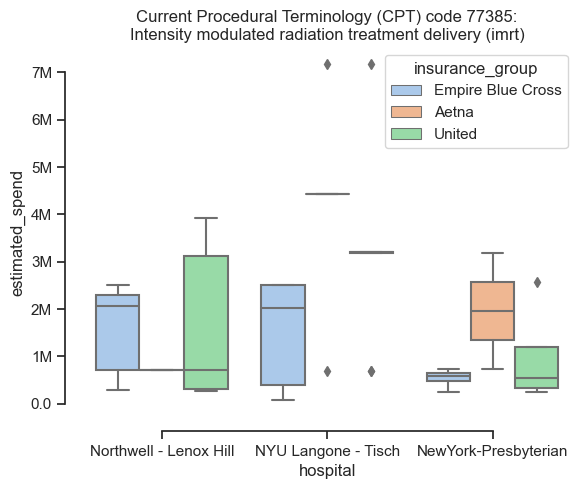

77412
hospital                insurance_group  
NYU Langone - Tisch     Empire Blue Cross    73
                        Medicare             31
                        United               15
                        Medicaid             13
                        Aetna                12
NewYork-Presbyterian    Medicaid              7
                        Medicare              6
                        Empire Blue Cross     4
                        United                4
                        Aetna                 2
Northwell - Lenox Hill  Empire Blue Cross    38
                        Medicare              9
                        United                7
                        Medicaid              6
                        Aetna                 3
Name: insurance_group, dtype: int64


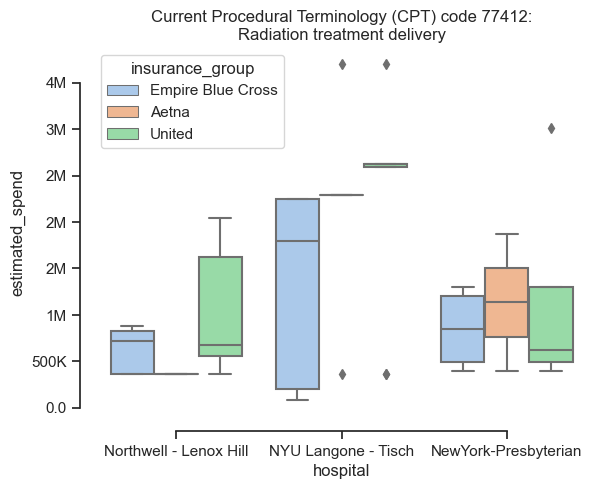

78452
hospital                insurance_group  
NYU Langone - Tisch     Empire Blue Cross    73
                        Medicare             31
                        United               15
                        Medicaid             13
                        Aetna                12
NewYork-Presbyterian    Medicaid              7
                        Medicare              6
                        Empire Blue Cross     5
                        United                4
                        Aetna                 2
Northwell - Lenox Hill  Empire Blue Cross    38
                        Aetna                24
                        Medicare              9
                        United                7
                        Medicaid              6
Name: insurance_group, dtype: int64


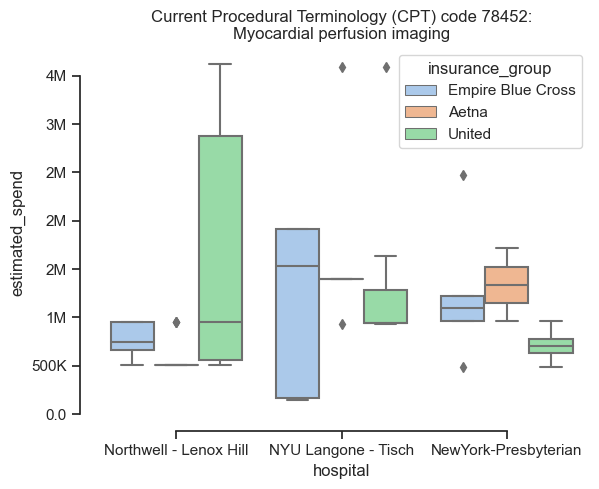

77067
hospital                insurance_group  
NYU Langone - Tisch     Empire Blue Cross    73
                        Medicare             31
                        United               15
                        Aetna                12
                        Medicaid             12
NewYork-Presbyterian    Medicaid              7
                        Medicare              6
                        Empire Blue Cross     5
                        United                4
                        Aetna                 2
Northwell - Lenox Hill  Empire Blue Cross    26
                        Aetna                21
                        United                6
                        Medicaid              5
Name: insurance_group, dtype: int64


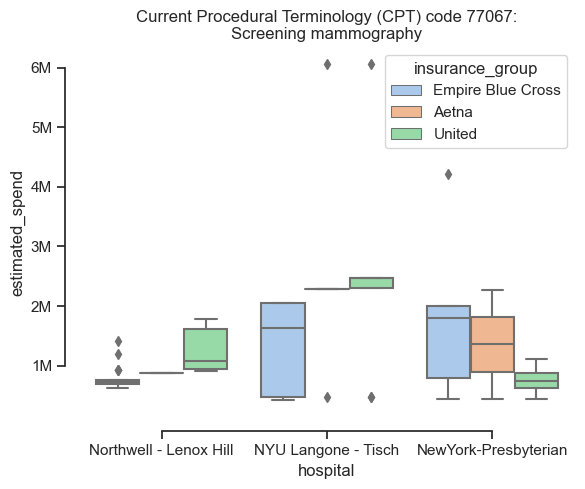

77373
hospital                insurance_group  
NYU Langone - Tisch     Empire Blue Cross    219
                        Medicare              93
                        United                45
                        Medicaid              39
                        Aetna                  6
NewYork-Presbyterian    Medicaid               7
                        Medicare               6
                        Empire Blue Cross      5
                        United                 4
                        Aetna                  2
Northwell - Lenox Hill  Empire Blue Cross     38
                        Medicare               9
                        United                 7
                        Medicaid               6
                        Aetna                  3
Name: insurance_group, dtype: int64


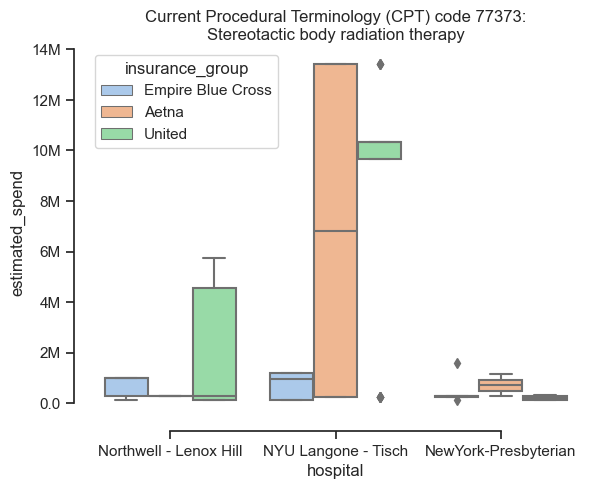

77301
hospital                insurance_group  
NYU Langone - Tisch     Empire Blue Cross    73
                        Medicare             31
                        United               15
                        Medicaid             13
                        Aetna                12
NewYork-Presbyterian    Medicaid              7
                        Medicare              6
                        Empire Blue Cross     5
                        United                4
                        Aetna                 2
Northwell - Lenox Hill  Empire Blue Cross    38
                        Aetna                24
                        Medicare              9
                        United                7
                        Medicaid              6
Name: insurance_group, dtype: int64


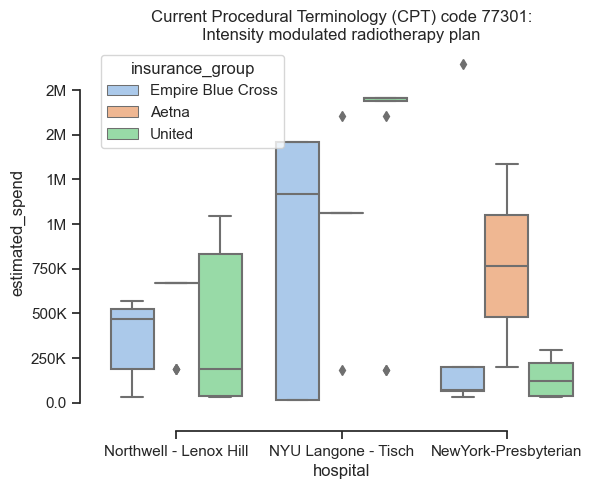

70553
hospital                insurance_group  
NYU Langone - Tisch     Empire Blue Cross    73
                        Medicare             31
                        United               15
                        Medicaid             13
                        Aetna                12
NewYork-Presbyterian    Medicaid              7
                        Medicare              6
                        Empire Blue Cross     5
                        United                4
                        Aetna                 2
Northwell - Lenox Hill  Empire Blue Cross    38
                        Aetna                24
                        Medicare              9
                        United                7
                        Medicaid              6
Name: insurance_group, dtype: int64


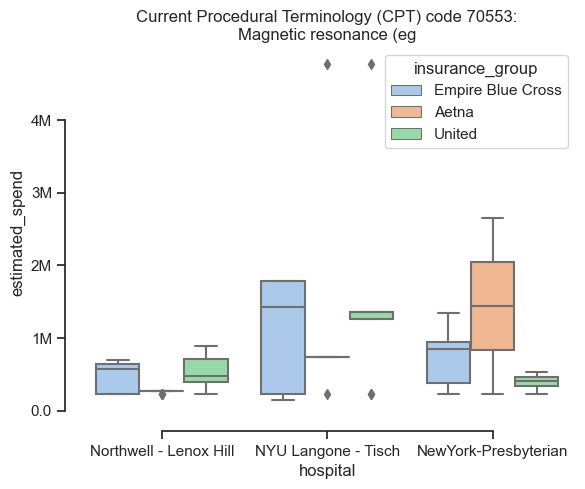

74176
hospital                insurance_group  
NYU Langone - Tisch     Empire Blue Cross    73
                        Medicare             31
                        United               15
                        Medicaid             13
                        Aetna                12
NewYork-Presbyterian    Medicaid              7
                        Medicare              6
                        Empire Blue Cross     5
                        United                4
                        Aetna                 2
Northwell - Lenox Hill  Empire Blue Cross    38
                        Aetna                24
                        Medicare              9
                        United                7
                        Medicaid              6
Name: insurance_group, dtype: int64


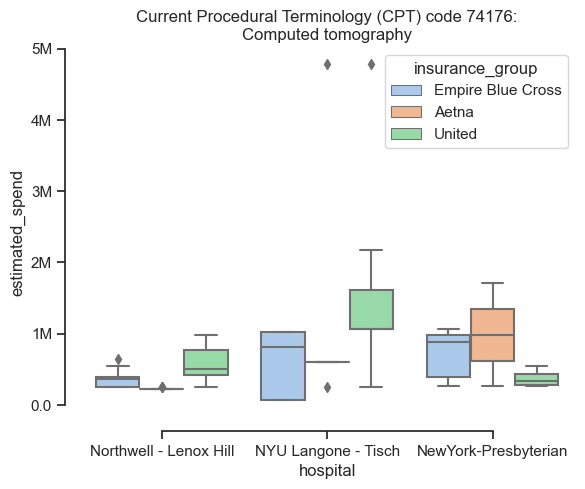

70450
hospital                insurance_group  
NYU Langone - Tisch     Empire Blue Cross    73
                        Medicare             31
                        United               15
                        Medicaid             13
                        Aetna                12
NewYork-Presbyterian    Medicaid              7
                        Medicare              6
                        Empire Blue Cross     5
                        United                4
                        Aetna                 2
Northwell - Lenox Hill  Empire Blue Cross    38
                        Aetna                24
                        Medicare              9
                        United                7
                        Medicaid              6
Name: insurance_group, dtype: int64


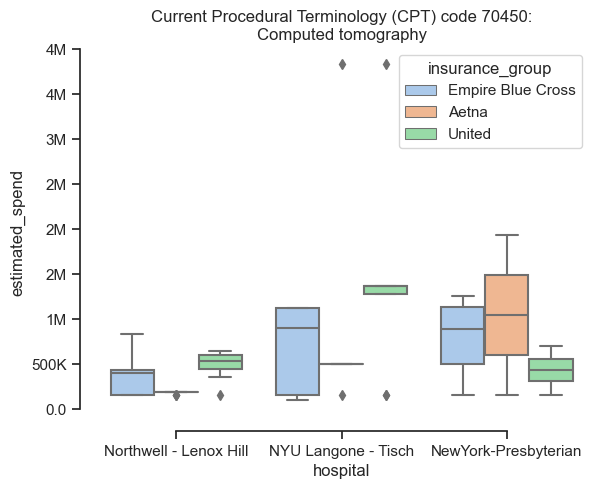

71260
hospital                insurance_group  
NYU Langone - Tisch     Empire Blue Cross    73
                        Medicare             31
                        United               15
                        Medicaid             13
                        Aetna                12
NewYork-Presbyterian    Medicaid              7
                        Medicare              6
                        Empire Blue Cross     5
                        United                4
                        Aetna                 2
Northwell - Lenox Hill  Empire Blue Cross    38
                        Aetna                24
                        Medicare              9
                        United                7
                        Medicaid              6
Name: insurance_group, dtype: int64


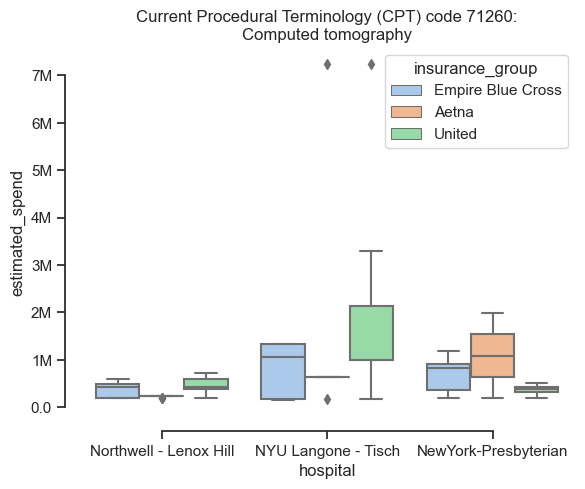

71045
hospital                insurance_group  
NYU Langone - Tisch     Empire Blue Cross    73
                        Medicare             31
                        United               15
                        Aetna                12
                        Medicaid              3
NewYork-Presbyterian    Medicaid              7
                        Medicare              6
                        Empire Blue Cross     5
                        United                4
                        Aetna                 2
Northwell - Lenox Hill  Empire Blue Cross    38
                        Aetna                24
                        Medicare              9
                        United                7
                        Medicaid              6
Name: insurance_group, dtype: int64


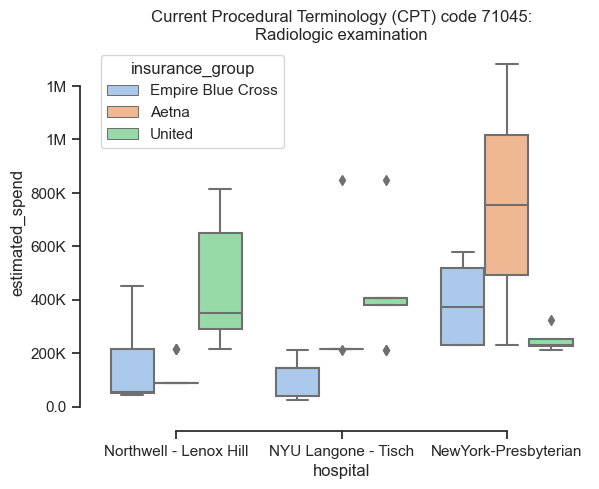

74183
hospital                insurance_group  
NYU Langone - Tisch     Empire Blue Cross    73
                        Medicare             31
                        United               15
                        Medicaid             13
                        Aetna                12
NewYork-Presbyterian    Medicaid              7
                        Medicare              6
                        Empire Blue Cross     5
                        United                4
                        Aetna                 2
Northwell - Lenox Hill  Empire Blue Cross    38
                        Aetna                24
                        Medicare              9
                        United                7
                        Medicaid              6
Name: insurance_group, dtype: int64


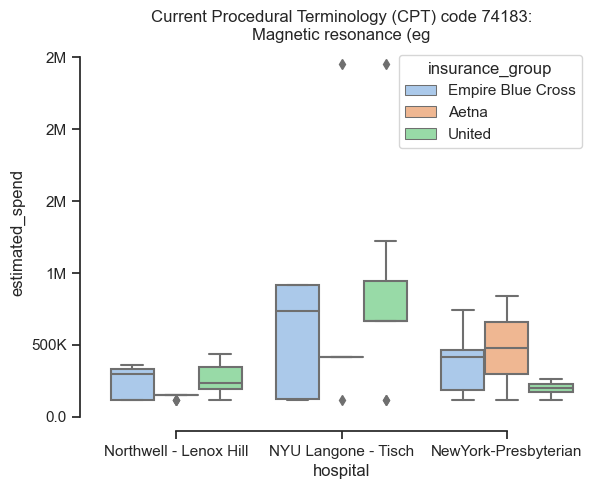

45380
hospital                insurance_group  
NYU Langone - Tisch     Empire Blue Cross    146
                        Medicare              62
                        United                29
                        Medicaid              26
                        Aetna                 23
NewYork-Presbyterian    Medicaid               7
                        Medicare               6
                        Empire Blue Cross      5
                        United                 4
                        Aetna                  2
Northwell - Lenox Hill  Empire Blue Cross     38
                        Aetna                 24
                        Medicare               9
                        United                 7
                        Medicaid               6
Name: insurance_group, dtype: int64


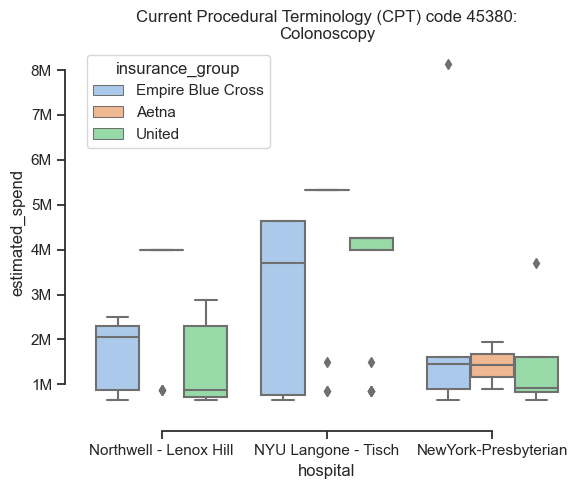

43239
hospital                insurance_group  
NYU Langone - Tisch     Empire Blue Cross    146
                        Medicare              62
                        United                29
                        Medicaid              26
                        Aetna                 23
NewYork-Presbyterian    Medicaid               7
                        Medicare               6
                        Empire Blue Cross      5
                        United                 4
                        Aetna                  2
Northwell - Lenox Hill  Empire Blue Cross     38
                        Aetna                 24
                        Medicare               9
                        United                 7
                        Medicaid               6
Name: insurance_group, dtype: int64


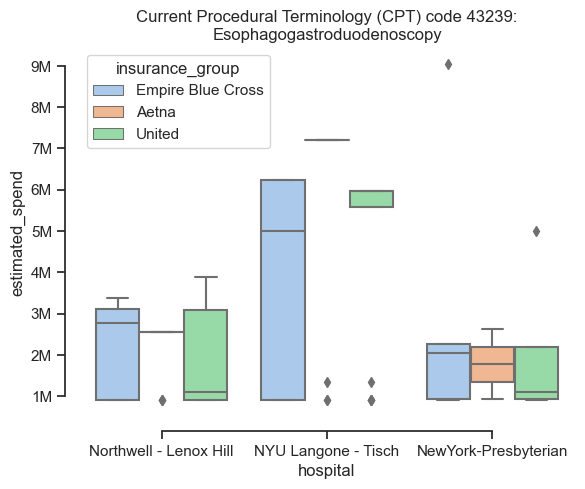

27447
hospital                insurance_group  
NYU Langone - Tisch     Empire Blue Cross    73
                        Medicare             31
                        United               14
                        Medicaid             13
                        Aetna                11
NewYork-Presbyterian    Medicaid              7
                        Medicare              6
                        Empire Blue Cross     5
                        United                4
                        Aetna                 2
Northwell - Lenox Hill  Empire Blue Cross    38
                        Aetna                24
                        Medicare              9
                        United                7
                        Medicaid              6
Name: insurance_group, dtype: int64


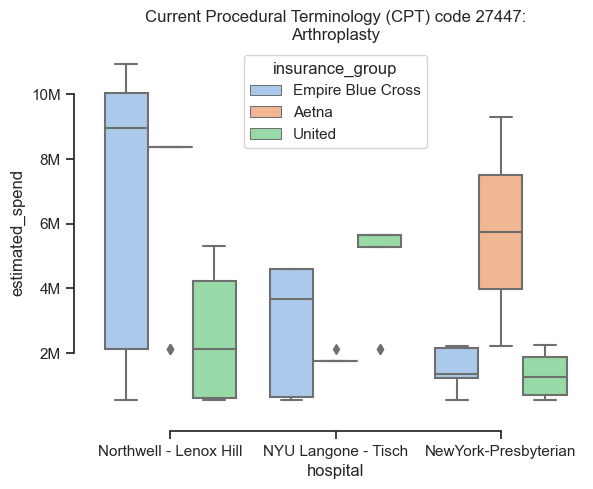

58558
hospital                insurance_group  
NYU Langone - Tisch     Empire Blue Cross    73
                        Medicare             31
                        United               14
                        Medicaid             13
                        Aetna                11
NewYork-Presbyterian    Medicaid              7
                        Medicare              6
                        Empire Blue Cross     5
                        United                4
                        Aetna                 2
Northwell - Lenox Hill  Empire Blue Cross    38
                        Aetna                24
                        Medicare              9
                        United                7
                        Medicaid              6
Name: insurance_group, dtype: int64


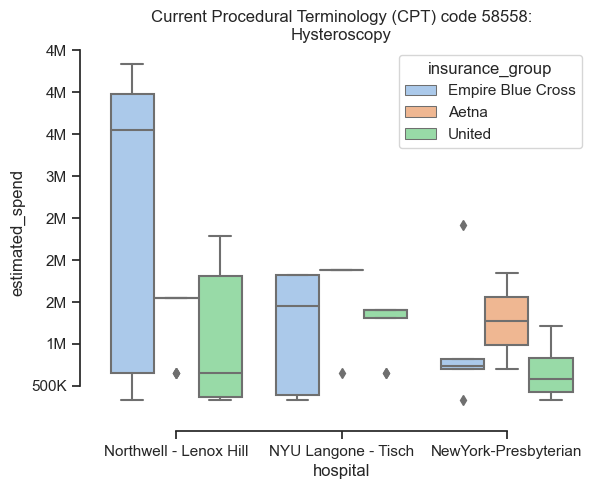

47562
hospital                insurance_group  
NYU Langone - Tisch     Empire Blue Cross    146
                        Medicare              62
                        United                29
                        Medicaid              26
                        Aetna                 23
NewYork-Presbyterian    Medicaid               7
                        Medicare               6
                        Empire Blue Cross      5
                        United                 4
                        Aetna                  2
Northwell - Lenox Hill  Empire Blue Cross     38
                        Aetna                 24
                        Medicare               9
                        United                 7
                        Medicaid               6
Name: insurance_group, dtype: int64


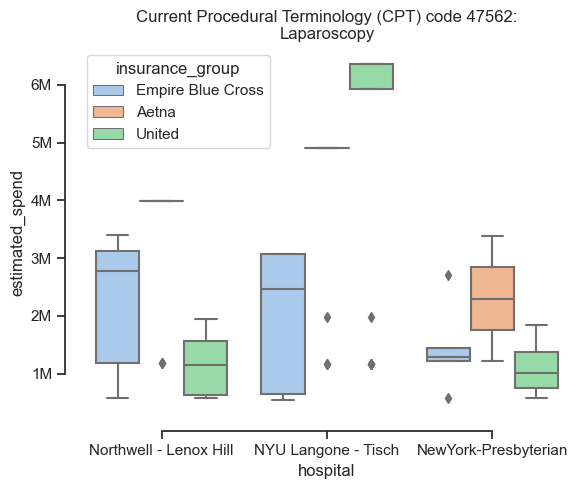

45385
hospital                insurance_group  
NYU Langone - Tisch     Empire Blue Cross    146
                        Medicare              62
                        United                29
                        Medicaid              26
                        Aetna                 23
NewYork-Presbyterian    Medicaid               7
                        Medicare               6
                        Empire Blue Cross      5
                        United                 4
                        Aetna                  2
Northwell - Lenox Hill  Empire Blue Cross     38
                        Aetna                 24
                        Medicare               9
                        United                 7
                        Medicaid               6
Name: insurance_group, dtype: int64


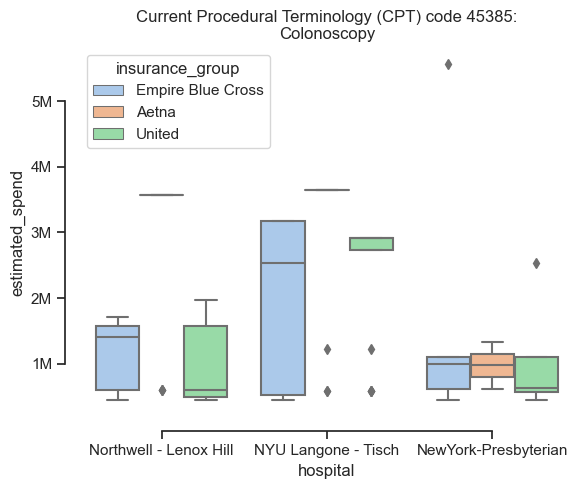

49650
hospital                insurance_group  
NYU Langone - Tisch     Empire Blue Cross    73
                        Medicare             31
                        United               14
                        Medicaid             13
                        Aetna                11
NewYork-Presbyterian    Medicaid              7
                        Medicare              6
                        Empire Blue Cross     5
                        United                4
                        Aetna                 2
Northwell - Lenox Hill  Empire Blue Cross    38
                        Aetna                24
                        Medicare              9
                        United                7
                        Medicaid              6
Name: insurance_group, dtype: int64


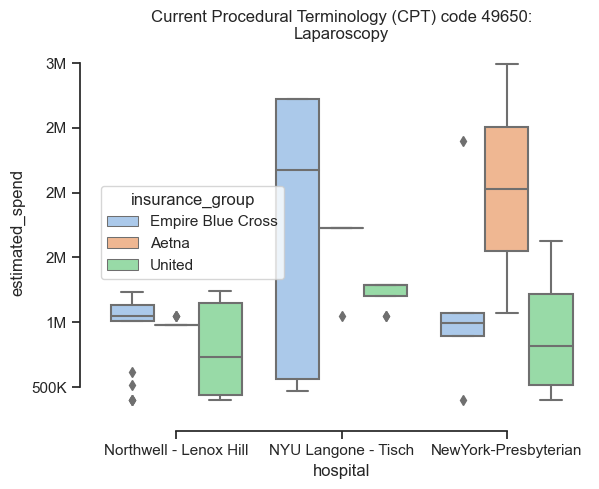

44970
hospital                insurance_group  
NYU Langone - Tisch     Empire Blue Cross    146
                        Medicare              62
                        United                28
                        Medicaid              26
                        Aetna                 22
NewYork-Presbyterian    Medicaid               7
                        Medicare               6
                        Empire Blue Cross      5
                        United                 4
                        Aetna                  2
Northwell - Lenox Hill  Empire Blue Cross     38
                        Aetna                 24
                        Medicare               9
                        United                 7
                        Medicaid               6
Name: insurance_group, dtype: int64


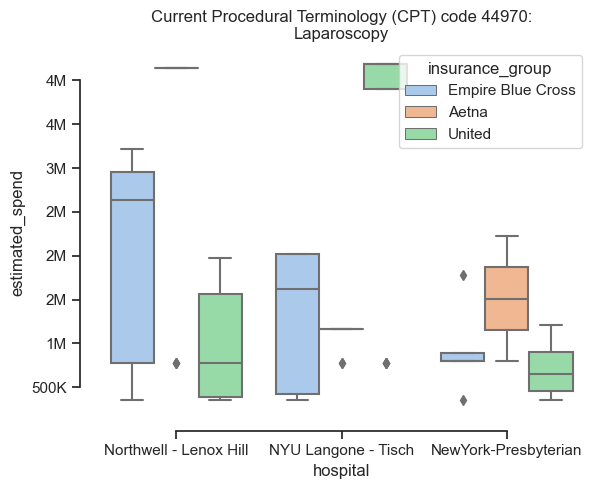

45378
hospital                insurance_group  
NYU Langone - Tisch     Empire Blue Cross    146
                        Medicare              62
                        United                29
                        Medicaid              26
                        Aetna                 23
NewYork-Presbyterian    Medicaid               7
                        Medicare               6
                        Empire Blue Cross      5
                        United                 4
                        Aetna                  2
Northwell - Lenox Hill  Empire Blue Cross     38
                        Aetna                 24
                        Medicare               9
                        United                 7
                        Medicaid               6
Name: insurance_group, dtype: int64


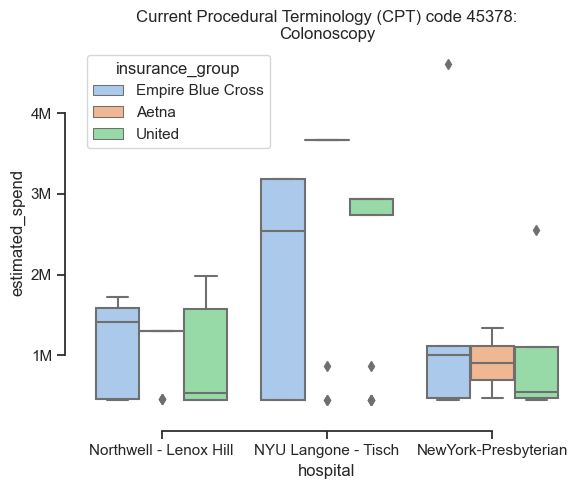

36430
58571
hospital                insurance_group  
NYU Langone - Tisch     Empire Blue Cross    146
                        Medicare              62
                        United                29
                        Medicaid              26
                        Aetna                 23
NewYork-Presbyterian    Medicaid               7
                        Medicare               6
                        Empire Blue Cross      5
                        United                 4
                        Aetna                  2
Northwell - Lenox Hill  Empire Blue Cross     38
                        Aetna                 24
                        Medicare               9
                        United                 7
                        Medicaid               6
Name: insurance_group, dtype: int64


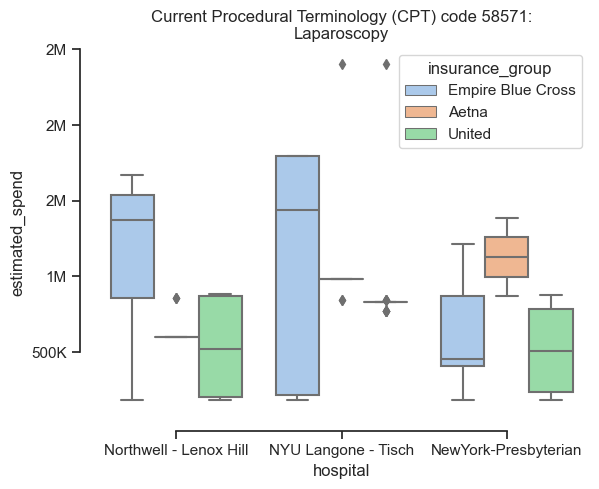

52356
hospital                insurance_group  
NYU Langone - Tisch     Empire Blue Cross    73
                        Medicare             31
                        United               14
                        Medicaid             13
                        Aetna                11
NewYork-Presbyterian    Medicaid              7
                        Medicare              6
                        Empire Blue Cross     5
                        United                4
                        Aetna                 2
Northwell - Lenox Hill  Empire Blue Cross    38
                        Aetna                24
                        Medicare              9
                        United                7
                        Medicaid              6
Name: insurance_group, dtype: int64


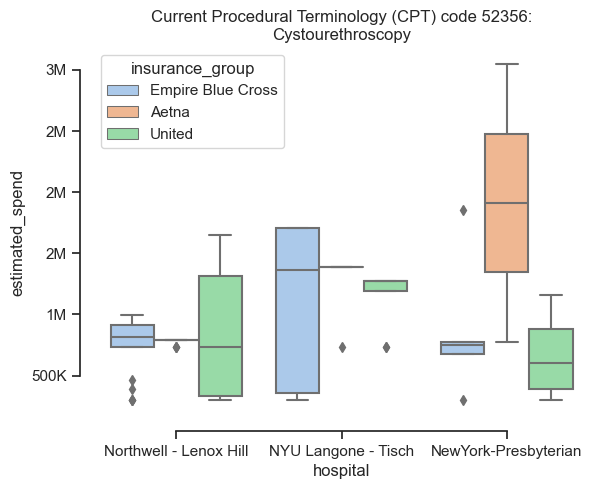

66984
hospital                insurance_group  
NYU Langone - Tisch     Empire Blue Cross    73
                        Medicare             31
                        United               14
                        Medicaid             13
                        Aetna                11
NewYork-Presbyterian    Medicaid              7
                        Medicare              6
                        Empire Blue Cross     5
                        United                4
                        Aetna                 2
Northwell - Lenox Hill  Empire Blue Cross    38
                        Aetna                24
                        Medicare              9
                        United                7
                        Medicaid              6
Name: insurance_group, dtype: int64


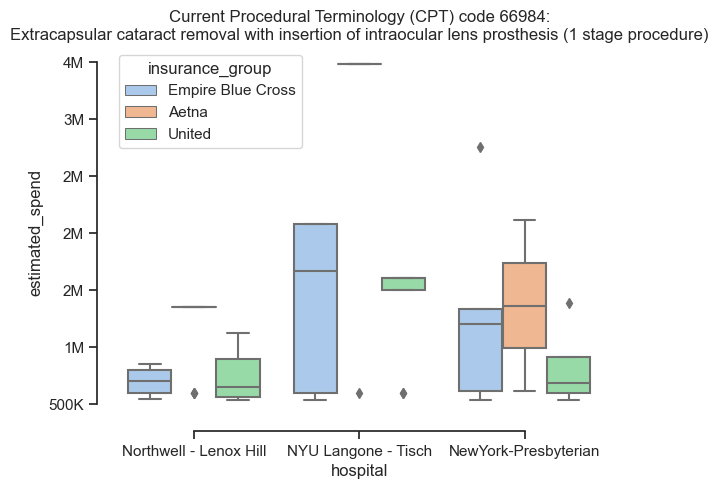

27130
hospital                insurance_group  
NYU Langone - Tisch     Empire Blue Cross    73
                        Medicare             31
                        United               14
                        Medicaid             13
                        Aetna                11
NewYork-Presbyterian    Medicaid              7
                        Medicare              6
                        Empire Blue Cross     5
                        United                4
                        Aetna                 2
Northwell - Lenox Hill  Empire Blue Cross    38
                        Aetna                24
                        Medicare              9
                        United                7
                        Medicaid              6
Name: insurance_group, dtype: int64


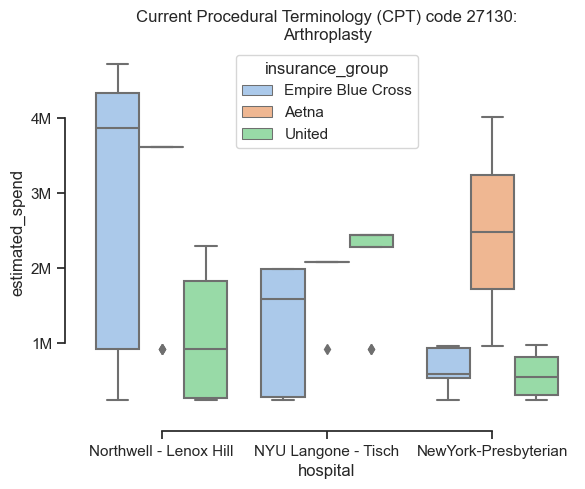

36000


In [107]:
for billing_code in df_top_cpt_codes_cost['billing_code']:
    print(billing_code)
    if billing_code in df['billing_code'].values:
      print(df[df['billing_code'] == billing_code].groupby('hospital').insurance_group.value_counts())
      sns.boxplot(x="hospital", y="estimated_spend",
            hue="insurance_group", 
            hue_order=["Empire Blue Cross", "Aetna", "United"],
            #palette=["m", "g"],
            data=df[df['billing_code'] == billing_code]).set(title=f"Current Procedural Terminology (CPT) code {billing_code}:\n{billing_code_to_description[billing_code].split(',')[0].lower().capitalize()}")
      sns.despine(offset=10, trim=True)
      # Apply the formatter to the x-axis
      plt.gca().yaxis.set_major_formatter(formatter)
      plt.show()